In [3]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(stringr)
library(Sierra)
library(presto)
library(ggplot2)
library(msigdbr)
library(fgsea)
library(sctransform)
library(tidyverse)
setwd('/data1/APA/Shun_Lau/data/')

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
"replacing previous import 'GenomicRanges::union' by 'dplyr::union' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::intersect' by 'dplyr::intersect' when loading 'Sierra'"
Warning message:
"replacing previous import 'GenomicRanges::setdiff' by 'dplyr::setdiff' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::tail' by 'utils::tail' when loading 'Sierra'"
Warning message:
"replacing previous import 'Gviz::head' by 'utils::head' when loading 'Sierra'"
Loading required package: Rcpp

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Registered S3 method overwritten by 'cli':
  method     f

In [15]:
samples_dir <- c('AD1', 'AD13','AD2','AD21','AD5','AD8','NC11','NC14',
                 'NC16','NC18','NC7','AD10','AD19','AD20','AD4','AD6',
                 'AD9','NC12','NC15','NC17','NC3')


In [34]:
all_samples_so <- list()
for (sample in samples_dir){
    log = paste0('reading bam files and creating the seurat object for sample: ',sample)
    print(log)
    data_dir = paste0(sample,'/outs/filtered_feature_bc_matrix/')
    expression_matrix <- Read10X(data.dir = data_dir)
    seurat_object = CreateSeuratObject(counts = expression_matrix)
    all_samples_so[[sample]] = seurat_object
}

[1] "reading bam files and creating the seurat object for sample: AD1"
[1] "reading bam files and creating the seurat object for sample: AD13"
[1] "reading bam files and creating the seurat object for sample: AD2"
[1] "reading bam files and creating the seurat object for sample: AD21"
[1] "reading bam files and creating the seurat object for sample: AD5"
[1] "reading bam files and creating the seurat object for sample: AD8"
[1] "reading bam files and creating the seurat object for sample: NC11"
[1] "reading bam files and creating the seurat object for sample: NC14"
[1] "reading bam files and creating the seurat object for sample: NC16"
[1] "reading bam files and creating the seurat object for sample: NC18"
[1] "reading bam files and creating the seurat object for sample: NC7"
[1] "reading bam files and creating the seurat object for sample: AD10"
[1] "reading bam files and creating the seurat object for sample: AD19"
[1] "reading bam files and creating the seurat object for sample: AD2

In [17]:
## a function to rename the cells
rename_barcodes <- function(so, sample_suffix){
    newnames <- gsub('-1', paste0('_', sample_suffix), Cells(so))
    so <- RenameCells(so, new.names = newnames)
    return(so)
}

In [20]:
for (sample in samples_dir){
    all_samples_so[[sample]] = rename_barcodes(all_samples_so[[sample]],
                                              sample)
}

An object of class Seurat 
36601 features across 5272 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

[1] "AAACGCTCATTAGGCT-1"

In [52]:
## process and qc the samples
qc_mito <- function(so){
    so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")
    so <- tryCatch({
        so <- subset(so, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)
        },
        error=function(cond){
            return(NULL)
        }
                   )
                   
        
    return(so)
}

In [53]:
for (sample in samples_dir){
    log <- paste0('processing the sample: ', sample)
    print(log)
    all_samples_so[[sample]] = qc_mito(all_samples_so[[sample]])
}

[1] "processing the sample: AD1"
[1] "processing the sample: AD13"
[1] "processing the sample: AD2"
[1] "processing the sample: AD21"
[1] "processing the sample: AD5"
[1] "processing the sample: AD8"
[1] "processing the sample: NC11"
[1] "processing the sample: NC14"
[1] "processing the sample: NC16"
[1] "processing the sample: NC18"
[1] "processing the sample: NC7"
[1] "processing the sample: AD10"
[1] "processing the sample: AD19"
[1] "processing the sample: AD20"
[1] "processing the sample: AD4"
[1] "processing the sample: AD6"
[1] "processing the sample: AD9"
[1] "processing the sample: NC12"
[1] "processing the sample: NC15"
[1] "processing the sample: NC17"
[1] "processing the sample: NC3"


In [54]:
all_samples_so

$AD1
An object of class Seurat 
36601 features across 4157 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD13
An object of class Seurat 
36601 features across 592 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD2
An object of class Seurat 
36601 features across 10642 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD21
An object of class Seurat 
36601 features across 3611 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD5
An object of class Seurat 
36601 features across 8948 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$AD8
An object of class Seurat 
36601 features across 673 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$NC11
An object of class Seurat 
36601 features across 413 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

$NC14
An object of 

In [56]:
### integerate the samples and process the 
all_samples_so <- lapply(X = all_samples_so, FUN = SCTransform)
features <- SelectIntegrationFeatures(object.list = all_samples_so, nfeatures = 3000)
all_samples_so <- PrepSCTIntegration(object.list = all_samples_so, anchor.features = features)
all.anchors <- FindIntegrationAnchors(object.list = all_samples_so, normalization.method = "SCT",
    anchor.features = features)
ad_ct_combined <- IntegrateData(anchorset = all.anchors, normalization.method = "SCT")
ad_ct_combined <- RunPCA(ad_ct_combined, verbose = FALSE)
ad_ct_combined <- RunUMAP(ad_ct_combined, reduction = "pca", dims = 1:30)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19535 by 4157

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4157 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 63 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19535 genes



  |======================================================================| 100%


Computing corrected count matrix for 19535 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.296152 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13715 by 592

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 592 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 60 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13715 genes



  |======================================================================| 100%


Computing corrected count matrix for 13715 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 17.29136 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21867 by 10642

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 92 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21867 genes



  |======================================================================| 100%


Computing corrected count matrix for 21867 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.272385 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18326 by 3611

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3611 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 82 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18326 genes



  |======================================================================| 100%


Computing corrected count matrix for 18326 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.338097 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20547 by 8948

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 103 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20547 genes



  |======================================================================| 100%


Computing corrected count matrix for 20547 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.052965 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13288 by 673

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 673 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 94 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13288 genes



  |======================================================================| 100%


Computing corrected count matrix for 13288 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 19.49036 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 11258 by 413

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 413 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in sqrt(1/i):
"NaNs produced"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warnin

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 123 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 11258 genes



  |======================================================================| 100%


Computing corrected count matrix for 11258 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 13.79935 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21102 by 7469

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21102 genes



  |======================================================================| 100%


Computing corrected count matrix for 21102 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.916729 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 13745 by 1657

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1657 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 97 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 13745 genes



  |======================================================================| 100%


Computing corrected count matrix for 13745 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 38.69432 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21773 by 9540

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 103 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21773 genes



  |======================================================================| 100%


Computing corrected count matrix for 21773 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.084985 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19102 by 4193

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4193 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 95 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19102 genes



  |======================================================================| 100%


Computing corrected count matrix for 19102 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.266443 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21285 by 10354

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 135 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21285 genes



  |======================================================================| 100%


Computing corrected count matrix for 21285 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.115936 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17725 by 1915

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1915 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |======================================================================| 100%


Found 134 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17725 genes



  |======================================================================| 100%


Computing corrected count matrix for 17725 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 45.01697 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20491 by 6570

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 74 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20491 genes



  |======================================================================| 100%


Computing corrected count matrix for 20491 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.791441 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18419 by 3715

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3715 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 104 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18419 genes



  |======================================================================| 100%


Computing corrected count matrix for 18419 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.37945 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19414 by 5484

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19414 genes



  |======================================================================| 100%


Computing corrected count matrix for 19414 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.695553 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22288 by 12440

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 97 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22288 genes



  |======================================================================| 100%


Computing corrected count matrix for 22288 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.36223 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19780 by 5257

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 80 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19780 genes



  |======================================================================| 100%


Computing corrected count matrix for 19780 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.745032 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21922 by 10925

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 101 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21922 genes



  |======================================================================| 100%


Computing corrected count matrix for 21922 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.253287 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19274 by 4307

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4307 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 106 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19274 genes



  |======================================================================| 100%


Computing corrected count matrix for 19274 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.350748 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2644 anchors

Filtering anchors

	Retained 2593 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12209 anchors

Filtering anchors

	Retained 7125 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2738 anchors

Filtering anchors

	Retained 1258 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6873 anchors

Filtering anchors

	Retained 5358 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2640 anchors

Filtering anchors

	Retained 1841 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9848 anchors

Fil

Finding anchors

	Found 17893 anchors

Filtering anchors

	Retained 8781 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3155 anchors

Filtering anchors

	Retained 1290 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1977 anchors

Filtering anchors

	Retained 693 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16600 anchors

Filtering anchors

	Retained 9328 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6610 anchors

Filtering anchors

	Retained 2363 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17115 anchors

Filtering anchors

	Retained 8666 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11351 anchors

Filtering anchors

	Retained 6043 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5481 anchors

Filtering anchors

	R

Finding anchors

	Found 12602 anchors

Filtering anchors

	Retained 6613 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2758 anchors

Filtering anchors

	Retained 1076 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 21782 anchors

Filtering anchors

	Retained 10992 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9584 anchors

Filtering anchors

	Retained 5142 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 19793 anchors

Filtering anchors

	Retained 8566 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3093 anchors

Filtering anchors

	Retained 1160 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 1948 anchors

Filtering anchors

	Retained 656 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15937 anchors

Filtering anchors

	

Finding anchors

	Found 8365 anchors

Filtering anchors

	Retained 6116 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12007 anchors

Filtering anchors

	Retained 8931 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5881 anchors

Filtering anchors

	Retained 4378 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10701 anchors

Filtering anchors

	Retained 8175 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8048 anchors

Filtering anchors

	Retained 5366 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9723 anchors

Filtering anchors

	Retained 7159 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 11937 anchors

Filtering anchors

	Retained 8729 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9139 anchors

Filtering anchors

	R

In [57]:
ad_ct_combined

An object of class Seurat 
64063 features across 112862 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [58]:
## now add some metadata

ad_ct_combined$cellnames <- Cells(ad_ct_combined)

In [80]:
samples <- sub(".*_(.*)", "\\1", ad_ct_combined$cellnames)
ad_ct_combined$samples <- samples
condition <- substr(samples, start = 1, stop = 2)
ad_ct_combined$condition <- condition

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



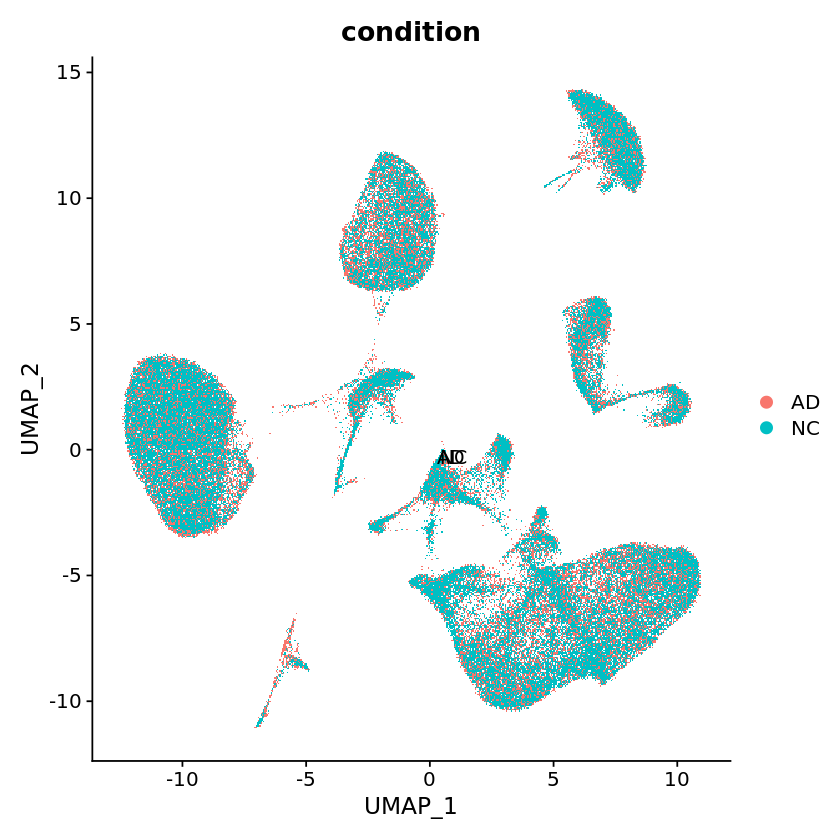

In [86]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'condition', label = T)

In [87]:
ref_ct_Dim <- readRDS('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_cell_types_GE_PFC.rds')
ref_ct_Dim

An object of class Seurat 
65217 features across 30147 samples within 1 assay 
Active assay: RNA (65217 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, tsne

In [89]:
ref_ct_Dim <- SCTransform(ref_ct_Dim, verbose = T)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 33415 by 30147

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |                                                                      |   0%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"


  |==================                                                    |  25%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |===================================                                   |  50%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |====================================================                  |  75%

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

  |======================================================================| 100%


Found 52 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 33415 genes



  |======================================================================| 100%


Computing corrected count matrix for 33415 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.850594 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [90]:
query.anchors <- FindTransferAnchors(reference = ref_ct_Dim, query = ad_ct_combined,
    dims = 1:30, reference.reduction = "pca", normalization.method='SCT')
predictions <- TransferData(anchorset = query.anchors, refdata = ref_ct_Dim$main_cellTypes,
    dims = 1:30)
ad_ct_combined <- AddMetaData(ad_ct_combined, metadata = predictions)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5428 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



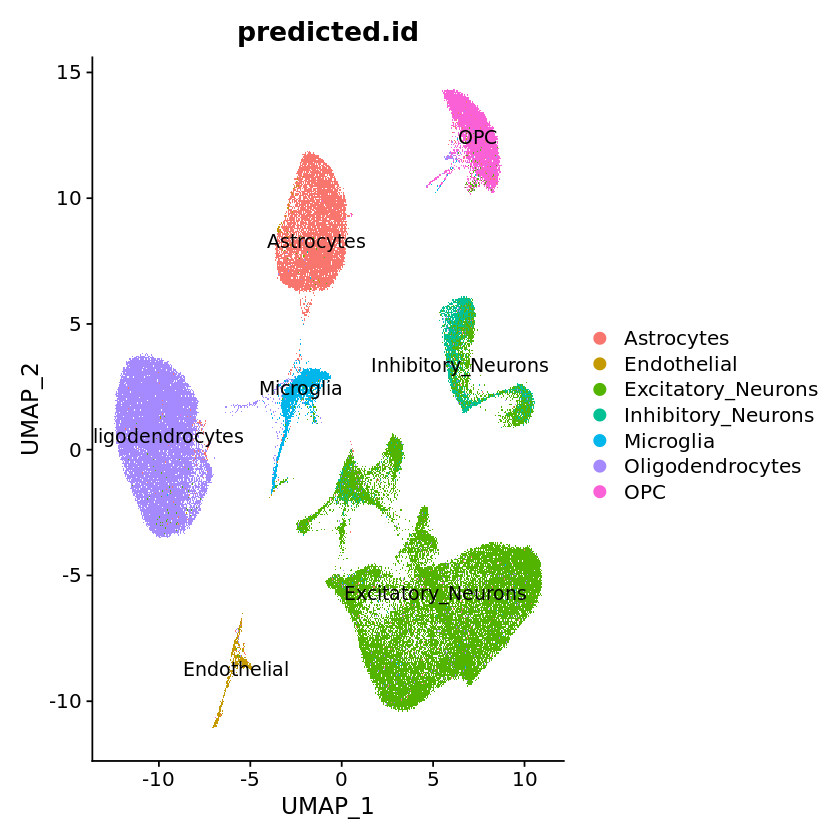

In [92]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'predicted.id', label = T)

In [93]:
ad_ct_combined$main_celltypes <- ad_ct_combined$predicted.id

In [99]:
query.anchors <- FindTransferAnchors(reference = ref_ct_Dim, query = ad_ct_combined,
    dims = 1:40, reference.reduction = "pca", normalization.method='SCT')
predictions <- TransferData(anchorset = query.anchors, refdata = ref_ct_Dim$cellType,
    dims = 1:40)
ad_ct_combined <- AddMetaData(ad_ct_combined, metadata = predictions)

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5493 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [100]:
ad_ct_combined$subcelltypes <- ad_ct_combined$predicted.id

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



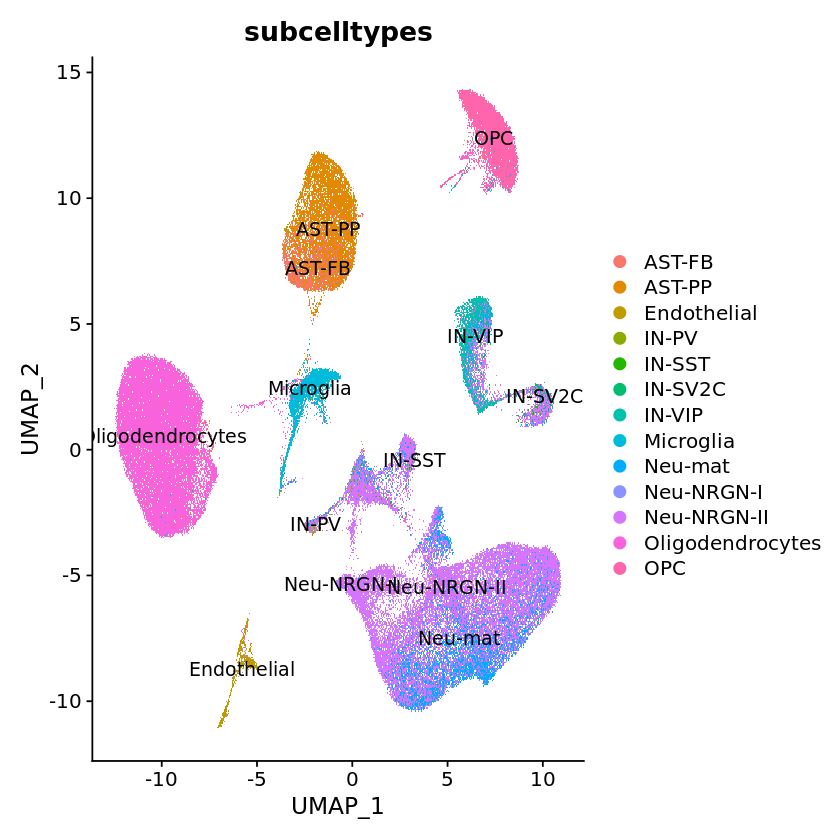

In [101]:
DimPlot(ad_ct_combined, reduction = 'umap', group.by = 'subcelltypes', label = T)

In [98]:
table(ref_ct_Dim$cellType)


          AST-FB           AST-PP      Endothelial            IN-PV 
            1106             1836              680             1123 
          IN-SST          IN-SV2C           IN-VIP             L2/3 
            1414              442             1357             3701 
              L4             L5/6          L5/6-CC        Microglia 
            2245              996             1253             1320 
         Neu-mat       Neu-NRGN-I      Neu-NRGN-II Oligodendrocytes 
             963              799             2066             5892 
             OPC 
            2954 

In [102]:
saveRDS(ad_ct_combined, file = 'rdata/ad_ct_ge_so.rds')

In [ ]:
saveRDS(ref_ct_Dim, file = '/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_cell_types_GE_PFC_SCT.rds')

In [107]:
cell_sample_df <- data.frame(cells= ad_ct_combined$cellnames, sample=ad_ct_combined$samples)
cell_sample_df

cells                sample
AAACCCAAGCTGAAAT_AD1 AAACCCAAGCTGAAAT_AD1 AD1   
AAACCCACAAATGGTA_AD1 AAACCCACAAATGGTA_AD1 AD1   
AAACCCACAATGAAAC_AD1 AAACCCACAATGAAAC_AD1 AD1   
AAACCCAGTAGCGAGT_AD1 AAACCCAGTAGCGAGT_AD1 AD1   
AAACGAATCAACCGAT_AD1 AAACGAATCAACCGAT_AD1 AD1   
AAACGCTAGCGATGGT_AD1 AAACGCTAGCGATGGT_AD1 AD1   
AAACGCTAGCTGAAGC_AD1 AAACGCTAGCTGAAGC_AD1 AD1   
AAACGCTCATACGCAT_AD1 AAACGCTCATACGCAT_AD1 AD1   
AAACGCTCATTAGGCT_AD1 AAACGCTCATTAGGCT_AD1 AD1   
AAACGCTGTACGACTT_AD1 AAACGCTGTACGACTT_AD1 AD1   
AAACGCTGTGTTGATC_AD1 AAACGCTGTGTTGATC_AD1 AD1   
AAACGCTTCCGCGATG_AD1 AAACGCTTCCGCGATG_AD1 AD1   
AAAGAACAGAGCATAT_AD1 AAAGAACAGAGCATAT_AD1 AD1   
AAAGAACAGTATCCTG_AD1 AAAGAACAGTATCCTG_AD1 AD1   
AAAGAACGTGTGTTTG_AD1 AAAGAACGTGTGTTTG_AD1 AD1   
AAAGAACTCAAAGGTA_AD1 AAAGAACTCAAAGGTA_AD1 AD1   
AAAGGATGTGCTGTCG_AD1 AAAGGATGTGCTGTCG_AD1 AD1   
AAAGGATTCCGGACTG_AD1 AAAGGATTCCGGACTG_AD1 AD1   
AAAGGGCAGAACCCGA_AD1 AAAGGGCAGAACCCGA_AD1 AD1   
AAAGGGCAGGGACTGT_AD1 AAAGGGCAGGGACTGT_AD1 AD1   
AAAGGGCAGTGCAGCA_AD1 AAAGGGCAGTGCAGCA_AD1 AD1   
AAAGGGCCAAGACCTT_AD1 AAAGGGCCAAGACCTT_AD1 AD1   
AAAGGGCCACGTGAGA_AD1 AAAGGGCCACGTGAGA_AD1 AD1   
AAAGGGCCACTACGGC_AD1 AAAGGGCCACTACGGC_AD1 AD1   
AAAGGGCGTGTTATCG_AD1 AAAGGGCGTGTTATCG_AD1 AD1   
AAAGGGCTCGGCGATC_AD1 AAAGGGCTCGGCGATC_AD1 AD1   
AAAGGTAAGGGTACAC_AD1 AAAGGTAAGGGTACAC_AD1 AD1   
AAAGGTACACCTGCAG_AD1 AAAGGTACACCTGCAG_AD1 AD1   
AAAGGTAGTGACAGCA_AD1 AAAGGTAGTGACAGCA_AD1 AD1   
AAAGGTAGTTCGAACT_AD1 AAAGGTAGTTCGAACT_AD1 AD1   
⋮                    ⋮                    ⋮     
TTTCGATTCCGCATAA_NC3 TTTCGATTCCGCATAA_NC3 NC3   
TTTGACTCAGGATCTT_NC3 TTTGACTCAGGATCTT_NC3 NC3   
TTTGACTCATGGGAAC_NC3 TTTGACTCATGGGAAC_NC3 NC3   
TTTGACTGTAACTGCT_NC3 TTTGACTGTAACTGCT_NC3 NC3   
TTTGACTGTATACAGA_NC3 TTTGACTGTATACAGA_NC3 NC3   
TTTGATCAGAGCTGAC_NC3 TTTGATCAGAGCTGAC_NC3 NC3   
TTTGATCAGGCGCTCT_NC3 TTTGATCAGGCGCTCT_NC3 NC3   
TTTGATCAGTTAGTGA_NC3 TTTGATCAGTTAGTGA_NC3 NC3   
TTTGATCCACCTTCGT_NC3 TTTGATCCACCTTCGT_NC3 NC3   
TTTGATCCATCGTGGC_NC3 TTTGATCCATCGTGGC_NC3 NC3   
TTTGATCGTCTCAAGT_NC3 TTTGATCGTCTCAAGT_NC3 NC3   
TTTGATCGTGGTCTTA_NC3 TTTGATCGTGGTCTTA_NC3 NC3   
TTTGATCGTTGTGTAC_NC3 TTTGATCGTTGTGTAC_NC3 NC3   
TTTGATCTCTACGGTA_NC3 TTTGATCTCTACGGTA_NC3 NC3   
TTTGGAGAGAGCCGTA_NC3 TTTGGAGAGAGCCGTA_NC3 NC3   
TTTGGAGAGCCGATCC_NC3 TTTGGAGAGCCGATCC_NC3 NC3   
TTTGGAGTCACCGGTG_NC3 TTTGGAGTCACCGGTG_NC3 NC3   
TTTGGTTAGACTTCGT_NC3 TTTGGTTAGACTTCGT_NC3 NC3   
TTTGGTTCAATAGTCC_NC3 TTTGGTTCAATAGTCC_NC3 NC3   
TTTGGTTCACTACCGG_NC3 TTTGGTTCACTACCGG_NC3 NC3   
TTTGGTTCACTACGGC_NC3 TTTGGTTCACTACGGC_NC3 NC3   
TTTGGTTCACTGCATA_NC3 TTTGGTTCACTGCATA_NC3 NC3   
TTTGGTTCAGGGACTA_NC3 TTTGGTTCAGGGACTA_NC3 NC3   
TTTGGTTGTACCCACG_NC3 TTTGGTTGTACCCACG_NC3 NC3   
TTTGTTGAGGAAGAAC_NC3 TTTGTTGAGGAAGAAC_NC3 NC3   
TTTGTTGAGGGATCAC_NC3 TTTGTTGAGGGATCAC_NC3 NC3   
TTTGTTGCAAGATTGA_NC3 TTTGTTGCAAGATTGA_NC3 NC3   
TTTGTTGGTTCGGCCA_NC3 TTTGTTGGTTCGGCCA_NC3 NC3   
TTTGTTGTCACAATGC_NC3 TTTGTTGTCACAATGC_NC3 NC3   
TTTGTTGTCCAACTAG_NC3 TTTGTTGTCCAACTAG_NC3 NC3

In [108]:
cell_sample_df <- cell_sample_df %>% mutate(barcodes = paste0(sub("(.*)_.*","\\1",cells),'-1'))
cell_sample_df

cells                sample barcodes          
AAACCCAAGCTGAAAT_AD1 AAACCCAAGCTGAAAT_AD1 AD1    AAACCCAAGCTGAAAT-1
AAACCCACAAATGGTA_AD1 AAACCCACAAATGGTA_AD1 AD1    AAACCCACAAATGGTA-1
AAACCCACAATGAAAC_AD1 AAACCCACAATGAAAC_AD1 AD1    AAACCCACAATGAAAC-1
AAACCCAGTAGCGAGT_AD1 AAACCCAGTAGCGAGT_AD1 AD1    AAACCCAGTAGCGAGT-1
AAACGAATCAACCGAT_AD1 AAACGAATCAACCGAT_AD1 AD1    AAACGAATCAACCGAT-1
AAACGCTAGCGATGGT_AD1 AAACGCTAGCGATGGT_AD1 AD1    AAACGCTAGCGATGGT-1
AAACGCTAGCTGAAGC_AD1 AAACGCTAGCTGAAGC_AD1 AD1    AAACGCTAGCTGAAGC-1
AAACGCTCATACGCAT_AD1 AAACGCTCATACGCAT_AD1 AD1    AAACGCTCATACGCAT-1
AAACGCTCATTAGGCT_AD1 AAACGCTCATTAGGCT_AD1 AD1    AAACGCTCATTAGGCT-1
AAACGCTGTACGACTT_AD1 AAACGCTGTACGACTT_AD1 AD1    AAACGCTGTACGACTT-1
AAACGCTGTGTTGATC_AD1 AAACGCTGTGTTGATC_AD1 AD1    AAACGCTGTGTTGATC-1
AAACGCTTCCGCGATG_AD1 AAACGCTTCCGCGATG_AD1 AD1    AAACGCTTCCGCGATG-1
AAAGAACAGAGCATAT_AD1 AAAGAACAGAGCATAT_AD1 AD1    AAAGAACAGAGCATAT-1
AAAGAACAGTATCCTG_AD1 AAAGAACAGTATCCTG_AD1 AD1    AAAGAACAGTATCCTG-1
AAAGAACGTGTGTTTG_AD1 AAAGAACGTGTGTTTG_AD1 AD1    AAAGAACGTGTGTTTG-1
AAAGAACTCAAAGGTA_AD1 AAAGAACTCAAAGGTA_AD1 AD1    AAAGAACTCAAAGGTA-1
AAAGGATGTGCTGTCG_AD1 AAAGGATGTGCTGTCG_AD1 AD1    AAAGGATGTGCTGTCG-1
AAAGGATTCCGGACTG_AD1 AAAGGATTCCGGACTG_AD1 AD1    AAAGGATTCCGGACTG-1
AAAGGGCAGAACCCGA_AD1 AAAGGGCAGAACCCGA_AD1 AD1    AAAGGGCAGAACCCGA-1
AAAGGGCAGGGACTGT_AD1 AAAGGGCAGGGACTGT_AD1 AD1    AAAGGGCAGGGACTGT-1
AAAGGGCAGTGCAGCA_AD1 AAAGGGCAGTGCAGCA_AD1 AD1    AAAGGGCAGTGCAGCA-1
AAAGGGCCAAGACCTT_AD1 AAAGGGCCAAGACCTT_AD1 AD1    AAAGGGCCAAGACCTT-1
AAAGGGCCACGTGAGA_AD1 AAAGGGCCACGTGAGA_AD1 AD1    AAAGGGCCACGTGAGA-1
AAAGGGCCACTACGGC_AD1 AAAGGGCCACTACGGC_AD1 AD1    AAAGGGCCACTACGGC-1
AAAGGGCGTGTTATCG_AD1 AAAGGGCGTGTTATCG_AD1 AD1    AAAGGGCGTGTTATCG-1
AAAGGGCTCGGCGATC_AD1 AAAGGGCTCGGCGATC_AD1 AD1    AAAGGGCTCGGCGATC-1
AAAGGTAAGGGTACAC_AD1 AAAGGTAAGGGTACAC_AD1 AD1    AAAGGTAAGGGTACAC-1
AAAGGTACACCTGCAG_AD1 AAAGGTACACCTGCAG_AD1 AD1    AAAGGTACACCTGCAG-1
AAAGGTAGTGACAGCA_AD1 AAAGGTAGTGACAGCA_AD1 AD1    AAAGGTAGTGACAGCA-1
AAAGGTAGTTCGAACT_AD1 AAAGGTAGTTCGAACT_AD1 AD1    AAAGGTAGTTCGAACT-1
⋮                    ⋮                    ⋮      ⋮                 
TTTCGATTCCGCATAA_NC3 TTTCGATTCCGCATAA_NC3 NC3    TTTCGATTCCGCATAA-1
TTTGACTCAGGATCTT_NC3 TTTGACTCAGGATCTT_NC3 NC3    TTTGACTCAGGATCTT-1
TTTGACTCATGGGAAC_NC3 TTTGACTCATGGGAAC_NC3 NC3    TTTGACTCATGGGAAC-1
TTTGACTGTAACTGCT_NC3 TTTGACTGTAACTGCT_NC3 NC3    TTTGACTGTAACTGCT-1
TTTGACTGTATACAGA_NC3 TTTGACTGTATACAGA_NC3 NC3    TTTGACTGTATACAGA-1
TTTGATCAGAGCTGAC_NC3 TTTGATCAGAGCTGAC_NC3 NC3    TTTGATCAGAGCTGAC-1
TTTGATCAGGCGCTCT_NC3 TTTGATCAGGCGCTCT_NC3 NC3    TTTGATCAGGCGCTCT-1
TTTGATCAGTTAGTGA_NC3 TTTGATCAGTTAGTGA_NC3 NC3    TTTGATCAGTTAGTGA-1
TTTGATCCACCTTCGT_NC3 TTTGATCCACCTTCGT_NC3 NC3    TTTGATCCACCTTCGT-1
TTTGATCCATCGTGGC_NC3 TTTGATCCATCGTGGC_NC3 NC3    TTTGATCCATCGTGGC-1
TTTGATCGTCTCAAGT_NC3 TTTGATCGTCTCAAGT_NC3 NC3    TTTGATCGTCTCAAGT-1
TTTGATCGTGGTCTTA_NC3 TTTGATCGTGGTCTTA_NC3 NC3    TTTGATCGTGGTCTTA-1
TTTGATCGTTGTGTAC_NC3 TTTGATCGTTGTGTAC_NC3 NC3    TTTGATCGTTGTGTAC-1
TTTGATCTCTACGGTA_NC3 TTTGATCTCTACGGTA_NC3 NC3    TTTGATCTCTACGGTA-1
TTTGGAGAGAGCCGTA_NC3 TTTGGAGAGAGCCGTA_NC3 NC3    TTTGGAGAGAGCCGTA-1
TTTGGAGAGCCGATCC_NC3 TTTGGAGAGCCGATCC_NC3 NC3    TTTGGAGAGCCGATCC-1
TTTGGAGTCACCGGTG_NC3 TTTGGAGTCACCGGTG_NC3 NC3    TTTGGAGTCACCGGTG-1
TTTGGTTAGACTTCGT_NC3 TTTGGTTAGACTTCGT_NC3 NC3    TTTGGTTAGACTTCGT-1
TTTGGTTCAATAGTCC_NC3 TTTGGTTCAATAGTCC_NC3 NC3    TTTGGTTCAATAGTCC-1
TTTGGTTCACTACCGG_NC3 TTTGGTTCACTACCGG_NC3 NC3    TTTGGTTCACTACCGG-1
TTTGGTTCACTACGGC_NC3 TTTGGTTCACTACGGC_NC3 NC3    TTTGGTTCACTACGGC-1
TTTGGTTCACTGCATA_NC3 TTTGGTTCACTGCATA_NC3 NC3    TTTGGTTCACTGCATA-1
TTTGGTTCAGGGACTA_NC3 TTTGGTTCAGGGACTA_NC3 NC3    TTTGGTTCAGGGACTA-1
TTTGGTTGTACCCACG_NC3 TTTGGTTGTACCCACG_NC3 NC3    TTTGGTTGTACCCACG-1
TTTGTTGAGGAAGAAC_NC3 TTTGTTGAGGAAGAAC_NC3 NC3    TTTGTTGAGGAAGAAC-1
TTTGTTGAGGGATCAC_NC3 TTTGTTGAGGGATCAC_NC3 NC3    TTTGTTGAGGGATCAC-1
TTTGTTGCAAGATTGA_NC3 TTTGTTGCAAGATTGA_NC3 NC3    TTTGTTGCAAGATTGA-1
TTTGTTGGT

In [113]:
for (sample in unique(ad_ct_combined$samples)){
    tmp_df <- cell_sample_df[cell_sample_df$sample == sample,]
    outname <- paste0('bams_in/',sample,'_barcodes.tsv')
    write.table(tmp_df$barcodes, file=outname, quote=F, row.names=F, col.names=F)
}

In [115]:
outfile <- file("bams_in/subset_bamfiles.sh")
outlines = c()
for (sample in unique(ad_ct_combined$samples)){
    bc = paste0(sample,'_barcodes.tsv')
    bamfiles = paste0(' /data1/APA/Shun_Lau/data/raw_data/',sample,'/outs/possorted_genome_bam.bam')
    outname = paste0(" ",sample,'_filtered.bam')
    subset_arg = '~/softwares/subset_bam --bam '
    bc_arg = ' --cell-barcodes '
    out_arg = ' --out-bam'
    outline = paste0(subset_arg,bamfiles, bc_arg, bc, out_arg,outname, " &")
    print(outline)
    outlines <- append(outlines, outline)
}
writeLines(outlines, outfile)
close(outfile)

[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD1/outs/possorted_genome_bam.bam --cell-barcodes AD1_barcodes.tsv --out-bam AD1_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD13/outs/possorted_genome_bam.bam --cell-barcodes AD13_barcodes.tsv --out-bam AD13_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD2/outs/possorted_genome_bam.bam --cell-barcodes AD2_barcodes.tsv --out-bam AD2_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD21/outs/possorted_genome_bam.bam --cell-barcodes AD21_barcodes.tsv --out-bam AD21_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD5/outs/possorted_genome_bam.bam --cell-barcodes AD5_barcodes.tsv --out-bam AD5_filtered.bam &"
[1] "~/softwares/subset_bam --bam  /data1/APA/Shun_Lau/data/raw_data/AD8/outs/possorted_genome_bam.bam --cell-barcodes AD8_barcodes.tsv --out-bam AD8_filtered.bam &

In [42]:
ge_so <- readRDS('rdata/ad_ct_ge_so.rds')
ge_so

An object of class Seurat 
64063 features across 112862 samples within 3 assays 
Active assay: integrated (3000 features, 3000 variable features)
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

In [4]:
Cells(ge_so)[10]

[1] "AAACGCTGTACGACTT_AD1"

In [33]:
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
gtf_gr <- rtracklayer::import(reference.file)
gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")


Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



In [34]:
peak.annotations <- read.table("/data1/APA/Shun_Lau/data/sierra_out/Shun_AD_CT_peaks_annotated.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)


In [35]:
peak.counts <- ReadPeakCounts(data.dir = "/data1/APA/Shun_Lau/data/sierra_out/Shun_AD_CT_Sierra_aggregate/")
peaks_so <- NewPeakSeurat(peak.data = peak.counts, 
                              annot.info = peak.annotations, 
                              min.cells = 50, min.peaks = 200)
peaks_so

[1] "Creating Seurat object with 370249 peaks and 112862 cells"


Warning message:
"The following arguments are not used: row.names"


[1] "Preparing feature table for DEXSeq"
[1] "No t-SNE coodinates included"
[1] "No UMAP coordinates included"


An object of class Seurat 
363250 features across 112862 samples within 1 assay 
Active assay: RNA (363250 features, 0 variable features)

In [40]:
peaks_so$nCount_peaks <- peaks_so$nCount_RNA
peaks_so$nFeature_peaks <- peaks_so$nFeature_RNA

In [43]:
cells_to_subset <- Cells(ge_so)

In [44]:
peaks_so$cellnames <- Cells(peaks_so)

In [45]:
peaks_so <- subset(peaks_so, subset = cellnames %in% cells_to_subset)

In [46]:
peaks_so <- AddMetaData(peaks_so, metadata = ge_so@meta.data)

In [14]:
table(peaks_so$main_celltypes)


        Astrocytes        Endothelial Excitatory_Neurons Inhibitory_Neurons 
             13819               1410              47090               5027 
         Microglia   Oligodendrocytes                OPC 
              4818              31973               8725 

In [47]:
### need to add the conditions to the celltypes :/
ct_cnd <- data.frame(cond=ge_so$condition, celltype=ge_so$main_celltypes)
ct_cnd = ct_cnd %>% mutate(ct_cnd=paste0(cond,"_",celltype))
ct_cnd

cond celltype           ct_cnd               
AAACCCAAGCTGAAAT_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAACCCACAAATGGTA_AD1 AD   Microglia          AD_Microglia         
AAACCCACAATGAAAC_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAACCCAGTAGCGAGT_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAACGAATCAACCGAT_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAACGCTAGCGATGGT_AD1 AD   Astrocytes         AD_Astrocytes        
AAACGCTAGCTGAAGC_AD1 AD   OPC                AD_OPC               
AAACGCTCATACGCAT_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAACGCTCATTAGGCT_AD1 AD   Astrocytes         AD_Astrocytes        
AAACGCTGTACGACTT_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAACGCTGTGTTGATC_AD1 AD   OPC                AD_OPC               
AAACGCTTCCGCGATG_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGAACAGAGCATAT_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGAACAGTATCCTG_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGAACGTGTGTTTG_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGAACTCAAAGGTA_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGGATGTGCTGTCG_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGGATTCCGGACTG_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGGGCAGAACCCGA_AD1 AD   Inhibitory_Neurons AD_Inhibitory_Neurons
AAAGGGCAGGGACTGT_AD1 AD   OPC                AD_OPC               
AAAGGGCAGTGCAGCA_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGGGCCAAGACCTT_AD1 AD   Microglia          AD_Microglia         
AAAGGGCCACGTGAGA_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGGGCCACTACGGC_AD1 AD   OPC                AD_OPC               
AAAGGGCGTGTTATCG_AD1 AD   Inhibitory_Neurons AD_Inhibitory_Neurons
AAAGGGCTCGGCGATC_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGGTAAGGGTACAC_AD1 AD   Microglia          AD_Microglia         
AAAGGTACACCTGCAG_AD1 AD   Oligodendrocytes   AD_Oligodendrocytes  
AAAGGTAGTGACAGCA_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
AAAGGTAGTTCGAACT_AD1 AD   Excitatory_Neurons AD_Excitatory_Neurons
⋮                    ⋮    ⋮                  ⋮                    
TTTCGATTCCGCATAA_NC3 NC   OPC                NC_OPC               
TTTGACTCAGGATCTT_NC3 NC   Astrocytes         NC_Astrocytes        
TTTGACTCATGGGAAC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGACTGTAACTGCT_NC3 NC   Oligodendrocytes   NC_Oligodendrocytes  
TTTGACTGTATACAGA_NC3 NC   Oligodendrocytes   NC_Oligodendrocytes  
TTTGATCAGAGCTGAC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGATCAGGCGCTCT_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGATCAGTTAGTGA_NC3 NC   OPC                NC_OPC               
TTTGATCCACCTTCGT_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGATCCATCGTGGC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGATCGTCTCAAGT_NC3 NC   Astrocytes         NC_Astrocytes        
TTTGATCGTGGTCTTA_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGATCGTTGTGTAC_NC3 NC   Microglia          NC_Microglia         
TTTGATCTCTACGGTA_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGAGAGAGCCGTA_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGAGAGCCGATCC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGAGTCACCGGTG_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGTTAGACTTCGT_NC3 NC   Astrocytes         NC_Astrocytes        
TTTGGTTCAATAGTCC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGTTCACTACCGG_NC3 NC   Oligodendrocytes   NC_Oligodendrocytes  
TTTGGTTCACTACGGC_NC3 NC   Inhibitory_Neurons NC_Inhibitory_Neurons
TTTGGTTCACTGCATA_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGGTTCAGGGACTA_NC3 NC   Astrocytes         NC_Astrocytes        
TTTGGTTGTACCCACG_NC3 NC   Astrocytes         NC_Astrocytes        
TTTGTTGAGGAAGAAC_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGTTGAGGGATCAC_NC3 NC   Microglia          NC_Microglia         
TTTGTTGCAAGATTGA_NC3 NC   Excitatory_Neurons NC_Excitatory_Neurons
TTTGTTGGTTCGGCCA_NC3 NC   Microglia          NC_Microglia         
T

In [48]:
peaks_so <- AddMetaData(peaks_so, metadata = ct_cnd)

In [23]:
peaks_so <- SetIdent(peaks_so, value = peaks_so$ct_cnd)

In [24]:
table(peaks_so$ct_cnd)


        AD_Astrocytes        AD_Endothelial AD_Excitatory_Neurons 
                 6936                   979                 23502 
AD_Inhibitory_Neurons          AD_Microglia   AD_Oligodendrocytes 
                 2448                  2304                 16230 
               AD_OPC         NC_Astrocytes        NC_Endothelial 
                 4262                  6883                   431 
NC_Excitatory_Neurons NC_Inhibitory_Neurons          NC_Microglia 
                23588                  2579                  2514 
  NC_Oligodendrocytes                NC_OPC 
                15743                  4463 

[1] "4981 expressed peaks in feature types UTR3"
[1] "4690 peaks after filtering out A-rich annotations"
[1] "967 genes detected with multiple peak sites expressed"
[1] "2744 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
SRSF5:chr14:69771448-69772005:1     UTR3               0.26427538     
CIRBP:chr19:1272739-1273229:1       UTR3               0.11633053     
PIK3R1:chr5:68298613-68301821:1     UTR3               0.21708791     
VSNL1:chr2:17656239-17656497:1      UTR3               0.10773551     
VSNL1:chr2:17656218-17656446:1      UTR3               0.11599013     
CNTNAP1:chr17:42699856-42699993:1   UTR3               0.14722151     
ANKRD12:chr18:9254996-9256874:1     UTR3               0.17296400     
ANKRD12:chr18:9255334-9256679:1     UTR3               0.10875670     
RABGAP1L:chr1:174994829-174995308:1 UTR3               0.12156412     
NECAB1:chr8:90956415-90957440:1     UTR3               0.11122458     
NRGN:chr11:124746319-124746811:1    UTR3               0.18347375     
MAP1B:chr5:72206267-72206687:1      UTR3               0.16713471     
MAP1B:chr5:72208564-72209169:1      UTR3               0.13615862     
VSNL1:chr2:17655088-17655868:1      UTR3               0.24508552     
TSPAN7:chrX:38688131-38688539:1     UTR3               0.08671602     
LUC7L3:chr17:50751561-50752402:1    UTR3               0.15551868     
NECAB1:chr8:90958326-90959166:1     UTR3               0.14190282     
UBA52:chr19:18573352-18575276:1     UTR3               0.15870990     
CNTNAP1:chr17:42699189-42699681:1   UTR3               0.13343545     
CCDC144A:chr17:16731839-16732049:1  UTR3               0.13543528     
MPRIP:chr17:17185053-17185706:1     UTR3               0.12496809     
NCAPH2:chr22:50524273-50524780:1    UTR3               0.09862990     
UNC80:chr2:209995505-209996216:1    UTR3               0.08667347     
SRSF11:chr1:70250468-70251421:1     UTR3               0.12879755     
SRSF11:chr1:70251117-70251658:1     UTR3               0.16126287     
RTN4:chr2:54972772-54973246:-1      UTR3               0.15828440     
RTN1:chr14:59595976-59596007:-1     UTR3               0.11854310     
MAPK10:chr4:86015832-86016509:-1    UTR3               0.12071313     
MAPK10:chr4:86015914-86016415:-1    UTR3               0.10913965     
HNRNPK:chr9:83968880-83969321:-1    UTR3               0.15479534     
SLC8A2:chr19:47428017-47428309:-1   UTR3               0.14339205     
TOMM20:chr1:235111637-235113860:-1  UTR3               0.14228576     
CCSAP:chr1:229321011-229321419:-1   UTR3               0.12335120     
CACNB4:chr2:151837781-151839497:-1  UTR3               0.13564803     
GPM6A:chr4:175633897-175634641:-1   UTR3               0.10667177     
ELAVL3:chr19:11451326-11451503:-1   UTR3               0.10531019     
SPOCK1:chr5:136978142-136978670:-1  UTR3               0.10292741     
CAMK2A:chr5:150219882-150220367:-1  UTR3               0.08050379     
GOLGA8A:chr15:34380043-34380649:-1  UTR3               0.08956685     
RTN1:chr14:59596396-59596644:-1     UTR3               0.10416135     
LONRF2:chr2:100273520-100273754:-1  UTR3               0.15198706     
LONRF2:chr2:100273409-100273844:-1  UTR3               0.16802825     
PPP3R1:chr2:68179179-68180499:-1    UTR3               0.11067143     
RSRP1:chr1:25242625-25245305:-1     UTR3               0.07488724     
NEFL:chr8:24952133-24952931:-1      UTR3               0.11033104     
ZRANB2:chr1:71063539-71064607:-1    UTR3               0.08360991     
ODF2L:chr1:86352887-86356544:-1     UTR3               0.09199217     
                                    population2_pct pvalue       padj        
SRSF5:chr14:69771448-69772005:1     0.21527896      1.202894e-56 8.251854e-54
CIRBP:chr19:1272739-1273229:1       0.08733254      3.896296e-30 5.345719e-28
PIK3R1:chr5:68298613-68301821:1     0.17835340      3.556854e-29 3.904003e-27
VSNL1:chr2:17656239-17656497:1      0.10861455      2.964654e-20 1.595100e-18
VSNL1:chr2:17656218-17656446:1      0.12018823      1.090619e-16 3.836741e-15
CNTNAP1:chr17:42699856-42699993:1   0.10115313      2.567392e-19 1.214642e-17
ANKRD12:chr18:9254996-9256874:1     0.13786671      5.736242e-16 1.943240e-14
ANKR

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.0592002419107682"


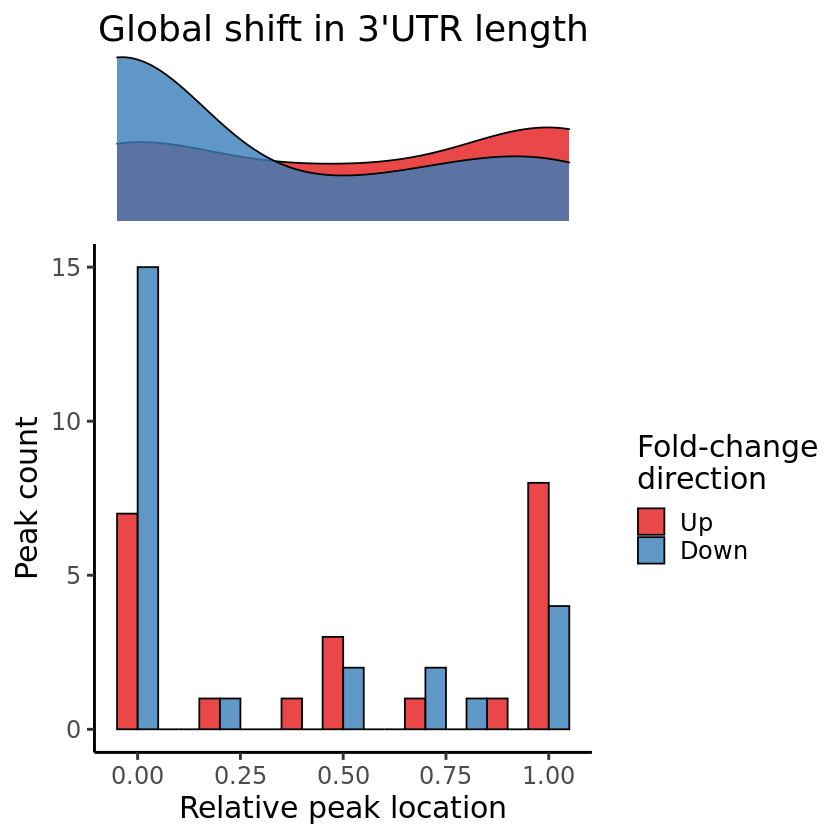

In [25]:
## lets go one celltype at a time
Exc_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Excitatory_Neurons', 
                                      population.2 = 'NC_Excitatory_Neurons')
Exc_utrshift
PlotUTRLengthShift(Exc_utrshift)

[1] "6398 expressed peaks in feature types UTR3"
[1] "6027 peaks after filtering out A-rich annotations"
[1] "1290 genes detected with multiple peak sites expressed"
[1] "3788 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
LUC7L3:chr17:50751561-50752402:1      UTR3               0.26511438     
SLC6A1:chr3:11037984-11038446:1       UTR3               0.23120915     
GRIA4:chr11:105912678-105913193:1     UTR3               0.15318627     
DDX6:chr11:118747763-118748094:-1     UTR3               0.14705882     
HSP90AA1:chr14:102084828-102085242:-1 UTR3               0.14338235     
ARHGAP21:chr10:24583609-24583998:-1   UTR3               0.21323529     
GOLGA8A:chr15:34379402-34379933:-1    UTR3               0.06004902     
HDAC5:chr17:44076746-44077131:-1      UTR3               0.07189542     
CCNI:chr4:77047454-77048153:-1        UTR3               0.15931373     
                                      population2_pct pvalue       padj       
LUC7L3:chr17:50751561-50752402:1      0.2985653       3.751752e-06 0.003552909
SLC6A1:chr3:11037984-11038446:1       0.3132997       1.344374e-05 0.008082537
GRIA4:chr11:105912678-105913193:1     0.1996898       9.171880e-05 0.026725449
DDX6:chr11:118747763-118748094:-1     0.1314463       1.803510e-04 0.035401056
HSP90AA1:chr14:102084828-102085242:-1 0.1217526       2.029243e-04 0.036603673
ARHGAP21:chr10:24583609-24583998:-1   0.1826289       2.641191e-04 0.045476509
GOLGA8A:chr15:34379402-34379933:-1    0.1015898       2.133722e-05 0.008082537
HDAC5:chr17:44076746-44077131:-1      0.1077937       5.207758e-05 0.017933625
CCNI:chr4:77047454-77048153:-1        0.1915471       7.124818e-05 0.022490677
                                      Log2_fold_change SiteLocation NumSites
LUC7L3:chr17:50751561-50752402:1      -0.3708166       2            4       
SLC6A1:chr3:11037984-11038446:1       -0.3213791       2            5       
GRIA4:chr11:105912678-105913193:1     -0.3704796       2            2       
DDX6:chr11:118747763-118748094:-1      0.2858196       3            3       
HSP90AA1:chr14:102084828-102085242:-1  0.4064878       1            7       
ARHGAP21:chr10:24583609-24583998:-1    0.3087591       2            2       
GOLGA8A:chr15:34379402-34379933:-1    -0.6179157       2            4       
HDAC5:chr17:44076746-44077131:-1      -0.5111508       3            3       
CCNI:chr4:77047454-77048153:-1        -0.2627075       1            2       
                                      FC_direction
LUC7L3:chr17:50751561-50752402:1      Down        
SLC6A1:chr3:11037984-11038446:1       Down        
GRIA4:chr11:105912678-105913193:1     Down        
DDX6:chr11:118747763-118748094:-1     Up          
HSP90AA1:chr14:102084828-102085242:-1 Up          
ARHGAP21:chr10:24583609-24583998:-1   Up          
GOLGA8A:chr15:34379402-34379933:-1    Down        
HDAC5:chr17:44076746-44077131:-1      Down        
CCNI:chr4:77047454-77048153:-1        Down

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.785494747118354"


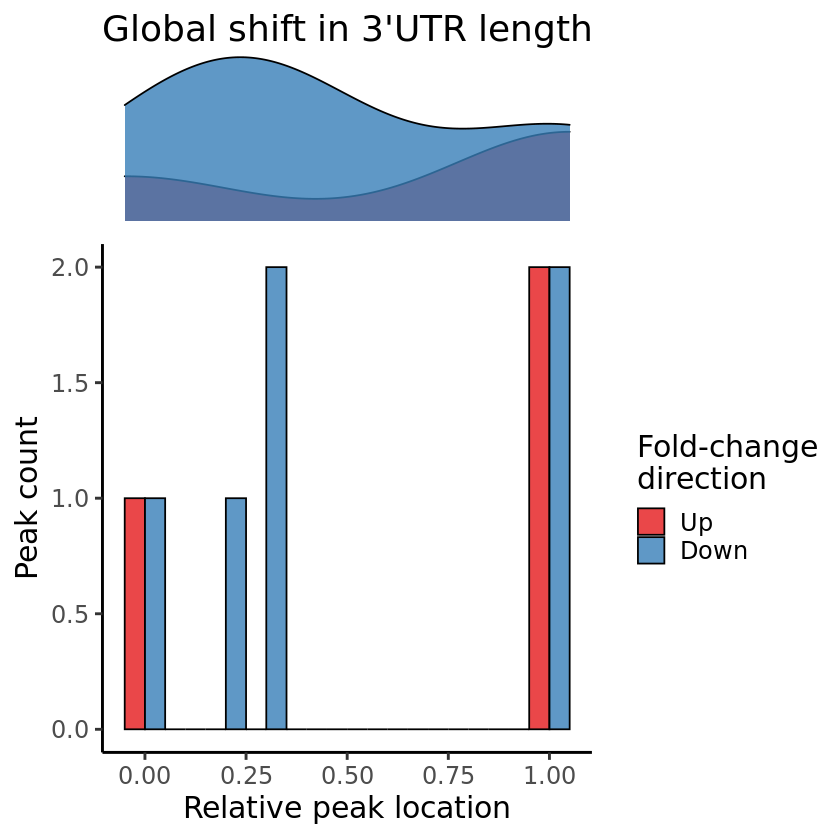

In [26]:
Inh_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Inhibitory_Neurons', 
                                      population.2 = 'NC_Inhibitory_Neurons')
Inh_utrshift
PlotUTRLengthShift(Inh_utrshift)

[1] "2962 expressed peaks in feature types UTR3"
[1] "2843 peaks after filtering out A-rich annotations"
[1] "581 genes detected with multiple peak sites expressed"
[1] "1761 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
SLC48A1:chr12:47782302-47782751:1   UTR3               0.15157116     
LUC7L3:chr17:50737003-50745919:1    UTR3               0.21983980     
LUC7L3:chr17:50741102-50745902:1    UTR3               0.17060998     
LUC7L3:chr17:50719565-50745980:1    UTR3               0.30881084     
PXK:chr3:58365635-58395476:1        UTR3               0.30418977     
PXK:chr3:58382230-58397334:1        UTR3               0.18995687     
SRSF11:chr1:70232044-70245010:1     UTR3               0.10893407     
SRSF11:chr1:70231218-70251152:1     UTR3               0.18817006     
UGT8:chr4:114668107-114676346:1     UTR3               0.18841651     
CNDP1:chr18:74556407-74567339:1     UTR3               0.09346888     
CNDP1:chr18:74559306-74567394:1     UTR3               0.08866297     
CNDP1:chr18:74556232-74562348:1     UTR3               0.07178065     
CNDP1:chr18:74559305-74562258:1     UTR3               0.06561922     
QKI:chr6:163575898-163578592:1      UTR3               0.24251386     
QKI:chr6:163577442-163578523:1      UTR3               0.15452865     
QKI:chr6:163577804-163578592:1      UTR3               0.15046211     
QKI:chr6:163577727-163578340:1      UTR3               0.12255083     
SRRM1:chr1:24648580-24649084:1      UTR3               0.13019100     
CIRBP:chr19:1272739-1273229:1       UTR3               0.11404806     
HNRNPA1:chr12:54286525-54287088:1   UTR3               0.10030807     
ANKRD12:chr18:9254996-9256874:1     UTR3               0.11417129     
SEPTIN7:chr7:35885736-35890873:1    UTR3               0.11417129     
SLC48A1:chr12:47781132-47781714:1   UTR3               0.14922982     
LUC7L3:chr17:50751561-50752402:1    UTR3               0.26642021     
LUC7L3:chr17:50752203-50752724:1    UTR3               0.27849661     
TMEM144:chr4:158254664-158254904:1  UTR3               0.09186691     
TMEM144:chr4:158254715-158255416:1  UTR3               0.34411583     
TMEM144:chr4:158253879-158254167:1  UTR3               0.07276648     
TMEM144:chr4:158253908-158254220:1  UTR3               0.10098583     
PXK:chr3:58425586-58426091:1        UTR3               0.25237215     
⋮                                   ⋮                  ⋮              
NKTR:chr3:42633632-42637019:1       UTR3               0.08743068     
SRSF11:chr1:70251117-70251658:1     UTR3               0.13943315     
SRSF11:chr1:70250468-70251421:1     UTR3               0.11441774     
PDE8A:chr15:85138028-85138880:1     UTR3               0.12415280     
CNDP1:chr18:74586738-74587212:1     UTR3               0.07054837     
SCD5:chr4:82630314-82630733:-1      UTR3               0.15058534     
DLG2:chr11:85154491-85627702:-1     UTR3               0.21417129     
DLG2:chr11:85284303-85627707:-1     UTR3               0.19285274     
ARPP19:chr15:52547098-52547668:-1   UTR3               0.11065927     
DLG1:chr3:197051468-197065645:-1    UTR3               0.18656808     
MAP7:chr6:136343672-136346172:-1    UTR3               0.20511399     
SLC24A2:chr9:19509035-19509794:-1   UTR3               0.10813309     
HNRNPU:chr1:244844748-244848994:-1  UTR3               0.10918053     
DST:chr6:56458133-56459291:-1       UTR3               0.24226741     
DST:chr6:56457987-56458924:-1       UTR3               0.26802218     
DST:chr6:56458039-56458207:-1       UTR3               0.15144794     
DST:chr6:56458107-56458149:-1       UTR3               0.11300062     
DST:chr6:56458361-56459750:-1       UTR3               0.11848429     
CCDC88A:chr2:55288294-55289237:-1   UTR3               0.07831177     
CCDC88A:chr2:55288247-55288613:-1   UTR3               0.09698090     
CCDC88A:chr2:55287842-55288945:-1   UTR3               0.19149723     
CCDC88A:chr2:55288341-55289697:-1   UTR3               0.07615527     
ARHGAP21:chr10:24628348-24630922:-1 UTR3               0.18582871     
OSBPL1A:chr18:24162045-24162452:-1  UTR3               0.11860752     
MAP7:chr6:136342681-136343217:-1    UTR3               0.143

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.236966547970994"


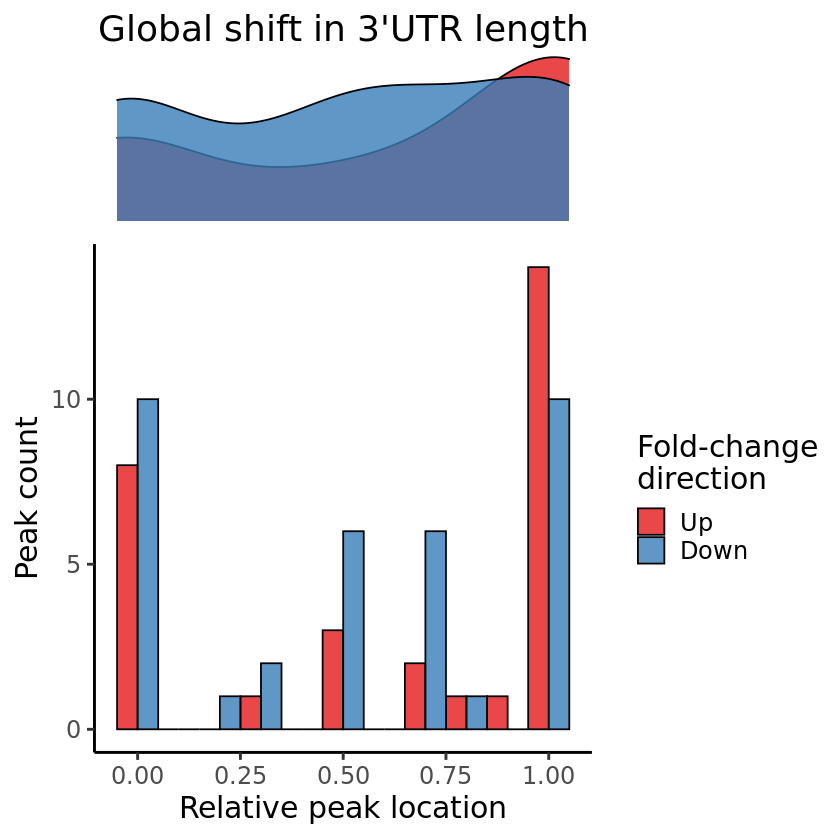

In [28]:
Olg_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Oligodendrocytes', 
                                      population.2 = 'NC_Oligodendrocytes')
Olg_utrshift
PlotUTRLengthShift(Olg_utrshift)

[1] "3374 expressed peaks in feature types UTR3"
[1] "3195 peaks after filtering out A-rich annotations"
[1] "658 genes detected with multiple peak sites expressed"
[1] "1848 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
APC:chr5:112840610-112842109:1        UTR3               0.28316032     
APC:chr5:112840220-112841378:1        UTR3               0.18454441     
APC:chr5:112840779-112841355:1        UTR3               0.14633795     
CIRBP:chr19:1274441-1274647:1         UTR3               0.08938870     
LUC7L3:chr17:50737003-50745919:1      UTR3               0.32497116     
LUC7L3:chr17:50741102-50745902:1      UTR3               0.27350058     
RHPN1:chr8:143383797-143384221:1      UTR3               0.13667820     
CHPT1:chr12:101719400-101720012:1     UTR3               0.13783160     
CHPT1:chr12:101713981-101720488:1     UTR3               0.25576701     
SLC48A1:chr12:47782302-47782751:1     UTR3               0.10178777     
ANKRD12:chr18:9254996-9256874:1       UTR3               0.12716263     
PAQR8:chr6:52407209-52407751:1        UTR3               0.14013841     
QKI:chr6:163575898-163578592:1        UTR3               0.13105536     
CCDC144A:chr17:16735002-16764253:1    UTR3               0.11663783     
CALM1:chr14:90405109-90405653:1       UTR3               0.13509227     
LUC7L2:chr7:139375819-139409653:1     UTR3               0.09818339     
PTPRZ1:chr7:121996273-121998144:1     UTR3               0.10438293     
TMBIM6:chr12:49764746-49764932:1      UTR3               0.10106690     
APC:chr5:112737764-112780815:1        UTR3               0.52220300     
APC:chr5:112754821-112780883:1        UTR3               0.44824106     
LUC7L3:chr17:50751561-50752402:1      UTR3               0.24754902     
LUC7L3:chr17:50752203-50752724:1      UTR3               0.28215110     
SLC48A1:chr12:47781132-47781714:1     UTR3               0.09111880     
AIG1:chr6:143333224-143339994:1       UTR3               0.05911188     
DTNA:chr18:34829219-34830328:1        UTR3               0.09731834     
SLCO1C1:chr12:20752684-20753386:1     UTR3               0.06531142     
GRAMD2B:chr5:126493361-126494033:1    UTR3               0.14158016     
KLC1:chr14:103685761-103686312:1      UTR3               0.09457901     
RIMKLB:chr12:8777191-8777671:1        UTR3               0.06098616     
CHPT1:chr12:101728908-101729742:1     UTR3               0.11130334     
⋮                                     ⋮                  ⋮              
HSP90AA1:chr14:102084828-102085242:-1 UTR3               0.19881776     
CADM1:chr11:115174232-115174712:-1    UTR3               0.26110150     
SCD5:chr4:82630314-82630733:-1        UTR3               0.12168397     
FAIM2:chr12:49870364-49889221:-1      UTR3               0.10827566     
DDX5:chr17:64502816-64503612:-1       UTR3               0.11490773     
DDX5:chr17:64502458-64503478:-1       UTR3               0.11836794     
HNRNPU:chr1:244844748-244848994:-1    UTR3               0.10265283     
HNRNPU:chr1:244847248-244853140:-1    UTR3               0.10467128     
HMGN3:chr6:79201688-79202417:-1       UTR3               0.14331027     
SAFB2:chr19:5598579-5610355:-1        UTR3               0.11634948     
SAFB2:chr19:5598664-5605147:-1        UTR3               0.10971742     
PPM1K:chr4:88257620-88257898:-1       UTR3               0.12557670     
DST:chr6:56457987-56458924:-1         UTR3               0.30478662     
DST:chr6:56458133-56459291:-1         UTR3               0.28402537     
DST:chr6:56458107-56458149:-1         UTR3               0.10640138     
DST:chr6:56458039-56458207:-1         UTR3               0.14734717     
DST:chr6:56458361-56459750:-1         UTR3               0.16089965     
KIAA0930:chr22:45211294-45212290:-1   UTR3               0.19579008     
KIAA0930:chr22:45211842-45212310:-1   UTR3               0.15671857     
SLC1A2:chr11:35259241-35260249:-1     UTR3               0.27119377     
SLC1A2:chr11:35259572-35260658:-1     UTR3               0.27667243     
SLC1A2:chr11:35259798-35260512:-1     UTR3               0.24192618     
HSP90AA1:chr14:102080969-102081627:-1 UTR3               0.38336217     
HSP90AA1:chr14:10208118

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.0384377702006361"


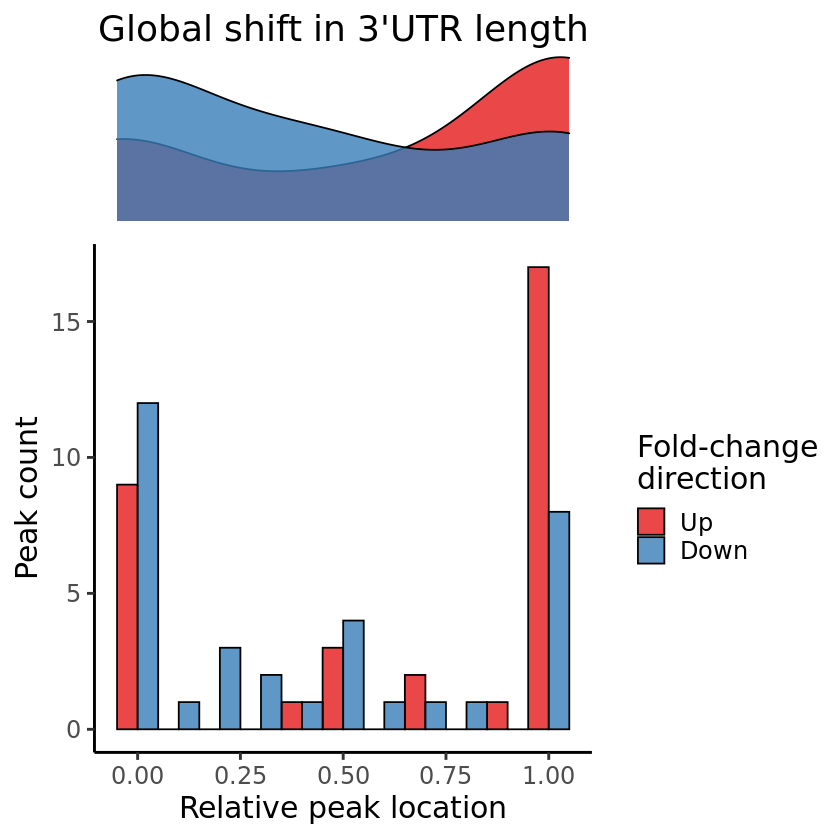

In [29]:
Ast_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Astrocytes', 
                                      population.2 = 'NC_Astrocytes')
Ast_utrshift
PlotUTRLengthShift(Ast_utrshift 

In [30]:
peaks_so$

An object of class Seurat 
363250 features across 112862 samples within 1 assay 
Active assay: RNA (363250 features, 0 variable features)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



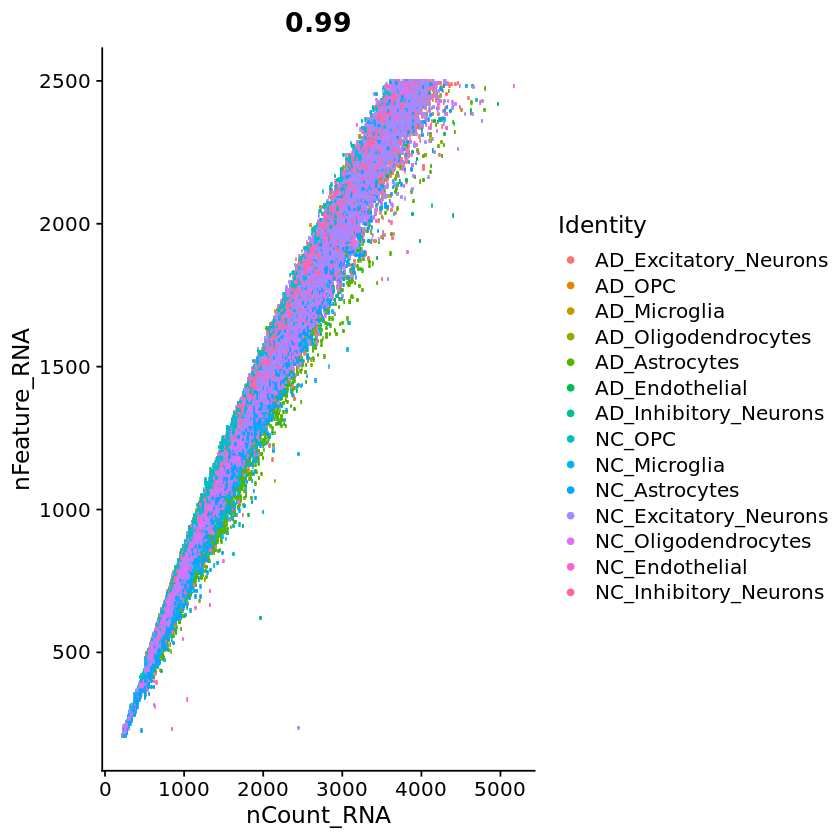

In [32]:
FeatureScatter(peaks_so, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [50]:
peaks_so <- SetIdent(peaks_so, value = peaks_so$condition)

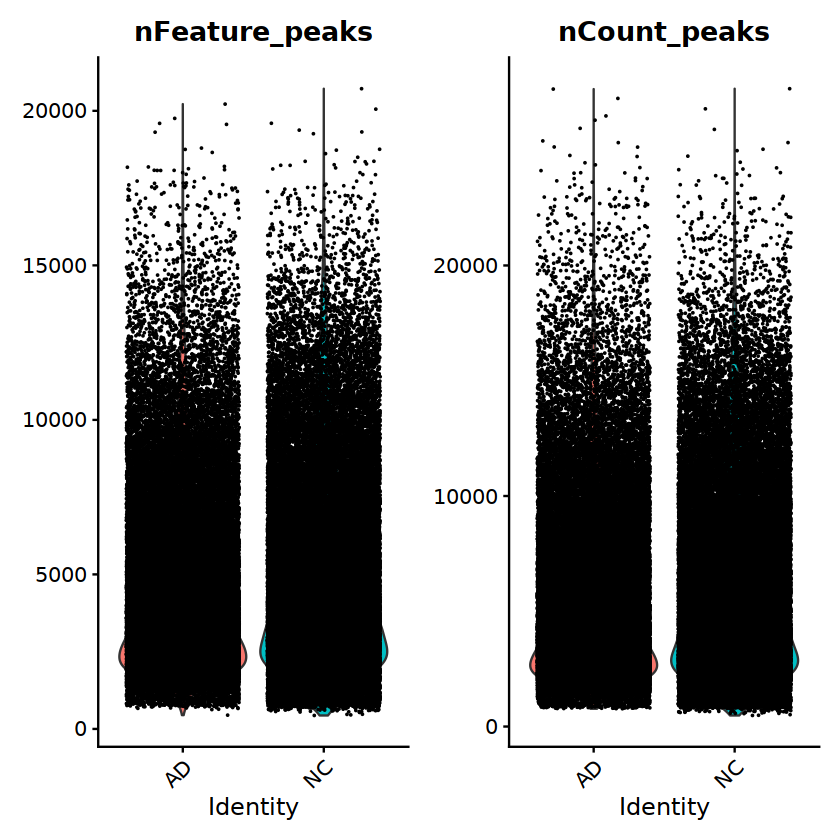

In [51]:
VlnPlot(peaks_so, features = c("nFeature_peaks", "nCount_peaks"), ncol = 2)

In [36]:
mean(peaks_so$nCount_RNA)

[1] 1454.569

In [37]:
mean(peaks_so$nFeature_RNA)

[1] 1062.023

In [42]:
table(peaks_so$samples)


  AD1  AD10  AD13  AD19   AD2  AD20  AD21   AD4   AD5   AD8   AD9  NC11  NC12 
 4157 10354   592  1915 10642  6570  3611  3715  8948   673  5484   413 12440 
 NC14  NC15  NC16  NC17  NC18   NC3   NC7 
 7469  5257  1657 10925  9540  4307  4193 

In [52]:
count_per_sample <- data.frame(samples=peaks_so$samples, peak_count=peaks_so$nCount_peaks,
                               features=peaks_so$nFeature_peaks)
# count_per_sample

ERROR: Error: Must group by variables found in `.data`.
* Column `samples` is not found.


In [37]:
count_per_sample

samples median_peak_count median_feature_count
1  AD1     4993.5            4158.0              
2  AD10    4623.0            3965.0              
3  AD13    5396.5            3946.0              
4  AD19    6652.0            5246.0              
5  AD2     4301.0            3667.0              
6  AD20    4771.0            4016.0              
7  AD21    3944.0            3292.0              
8  AD4     4313.0            3595.0              
9  AD5     3578.0            3076.5              
10 AD8     4591.0            3486.5              
11 AD9     3929.0            3282.0              
12 NC11    3599.0            2712.0              
13 NC12    4578.0            3905.0              
14 NC14    6053.0            5094.0              
15 NC15    5696.0            4868.0              
16 NC16    1781.0            1439.0              
17 NC17    4583.0            3932.5              
18 NC18    5267.0            4424.0              
19 NC3     5008.0            4138.0              
20 NC7     5026.0            4221.0

In [53]:
count_per_sample <- count_per_sample %>%
  group_by(samples) %>%
  summarise(median_peak_count = median(peak_count), median_feature_count=median(features))
count_per_sample

samples median_peak_count median_feature_count
1  AD1     4975.0            4138.0              
2  AD10    4589.0            3943.5              
3  AD13    5396.5            3946.0              
4  AD19    6645.0            5237.0              
5  AD2     4272.0            3644.0              
6  AD20    4700.0            3967.5              
7  AD21    3944.0            3291.0              
8  AD4     4085.0            3406.0              
9  AD5     3560.0            3066.0              
10 AD8     4582.0            3481.0              
11 AD9     3918.0            3273.5              
12 NC11    3599.0            2712.0              
13 NC12    4407.0            3770.5              
14 NC14    5843.0            4925.0              
15 NC15    5564.0            4768.0              
16 NC16    1768.0            1431.0              
17 NC17    4414.0            3785.0              
18 NC18    5101.0            4296.0              
19 NC3     4785.0            3968.0              
20 NC7     4933.0            4161.0

In [54]:
write.table(count_per_sample, file='results/Shun_AD_CT_peak_stat.tsv', sep='\t')

In [73]:
peaks_so$barcodes <- paste0(sub("(.*)_.*", "\\1", peaks_so$cellnames),'_1')
peaks_so$barcodes[10]

AAACCCAGTTCTCCCA_AD10 
 "AAACCCAGTTCTCCCA_1"

In [50]:
## read in the celltype identities from authors
celltype_bc <- read.table('rdata/Shun_AD_CT_celltype_metadata.csv', sep=',', header=T)
celltype_bc

ID                  Cell_type
1      AAACCCAAGCTGAAAT_1  Excit    
2      AAACCCACAAATGGTA_1  Mic      
3      AAACCCACAATGAAAC_1  Oligo    
4      AAACCCAGTAACCCTA_1  Excit    
5      AAACCCAGTAGCGAGT_1  Oligo    
6      AAACGAATCAACCGAT_1  Excit    
7      AAACGCTAGATGTAGT_1  Excit    
8      AAACGCTAGCGATGGT_1  Astro    
9      AAACGCTAGCTGAAGC_1  Excit    
10     AAACGCTAGTTCAACC_1  Excit    
11     AAACGCTCAGCTAACT_1  Oligo    
12     AAACGCTCATACGCAT_1  Excit    
13     AAACGCTCATTAGGCT_1  Astro    
14     AAACGCTGTACGACTT_1  Oligo    
15     AAACGCTGTCATCCCT_1  Oligo    
16     AAACGCTGTCTGTCCT_1  Oligo    
17     AAACGCTGTGTTGATC_1  Excit    
18     AAACGCTTCCGCGATG_1  Inhit    
19     AAAGAACAGAGCATAT_1  Inhit    
20     AAAGAACAGATAACGT_1  Oligo    
21     AAAGAACAGTATCCTG_1  Oligo    
22     AAAGAACGTGTGTTTG_1  Excit    
23     AAAGAACTCAAAGGTA_1  Oligo    
24     AAAGAACTCATGAGGG_1  Mic      
25     AAAGGATCACAGAGCA_1  Inhit    
26     AAAGGATGTGCTGTCG_1  Excit    
27     AAAGGATGTGGAACCA_1  Excit    
28     AAAGGATGTGTCCAAT_1  Astro    
29     AAAGGATTCCGGACTG_1  Excit    
30     AAAGGGCAGAACCCGA_1  Inhit    
⋮      ⋮                   ⋮        
169467 TTTGATCGTAGACTGG_21 Inhit    
169468 TTTGATCTCAAGCCTA_21 Excit    
169469 TTTGATCTCGACATCA_21 Excit    
169470 TTTGGAGAGATAGTCA_21 Excit    
169471 TTTGGAGAGGTTCCAT_21 Inhit    
169472 TTTGGAGAGTGAGCCA_21 Excit    
169473 TTTGGAGCAAACCGGA_21 Excit    
169474 TTTGGAGCAAGCCTGC_21 Inhit    
169475 TTTGGAGCACAGCATT_21 Excit    
169476 TTTGGAGGTAGTTAGA_21 Astro    
169477 TTTGGAGGTGGAAATT_21 Excit    
169478 TTTGGAGTCACTCGAA_21 Excit    
169479 TTTGGAGTCAGACATC_21 Excit    
169480 TTTGGAGTCCTAGCGG_21 Excit    
169481 TTTGGAGTCGAAGAAT_21 Oligo    
169482 TTTGGAGTCGCCGTGA_21 Excit    
169483 TTTGGAGTCTAAGCCA_21 Excit    
169484 TTTGGAGTCTTTACAC_21 Excit    
169485 TTTGGTTAGCGGGTAT_21 Endo     
169486 TTTGGTTAGGAGGTTC_21 Excit    
169487 TTTGGTTAGGCCTGCT_21 Inhit    
169488 TTTGGTTTCCAACCAA_21 Mic      
169489 TTTGGTTTCGCCGATG_21 Excit    
169490 TTTGGTTTCTGTAAGC_21 Astro    
169491 TTTGTTGAGACCCTTA_21 Inhit    
169492 TTTGTTGCAAATGATG_21 Excit    
169493 TTTGTTGCATTGAAAG_21 Excit    
169494 TTTGTTGTCCTTCACG_21 Mic      
169495 TTTGTTGTCGGTCAGC_21 Oligo    
169496 TTTGTTGTCTACACAG_21 Astro

In [60]:
length(unique(celltype_bc$ID))

[1] 169496

In [61]:
tst <- sub(".*_(.*)", "\\1", celltype_bc$IDID)
table(tst)

tst
    1    10    11    12    13    14    15    16    17    18    19     2    20 
 5758 15975  2048 15141  1663 10655  8191  4987 14090 11295  3697 14844  9059 
   21     3     4     5     6     7     8     9 
 8233  6220  6106 12324   590  6156  2494  9970 

In [64]:
table(peaks_so$samples)


  AD1  AD10  AD13  AD19   AD2  AD20  AD21   AD4   AD5   AD8   AD9  NC11  NC12 
 4157 10354   592  1915 10642  6570  3611  3715  8948   673  5484   413 12440 
 NC14  NC15  NC16  NC17  NC18   NC3   NC7 
 7469  5257  1657 10925  9540  4307  4193 

In [75]:
peaks_so$barcodes <- paste0(sub("(.*)_.*", "\\1", peaks_so$barcodes),"_",
                            gsub(".*?([0-9]+)", "\\1", peaks_so$samples))
peaks_so$barcodes[10]

AAACCCAGTTCTCCCA_AD10 
"AAACCCAGTTCTCCCA_10"

In [76]:
shared_bcs <- celltype_bc$ID[which(celltype_bc$ID %in% peaks_so$barcodes)]
length(shared_bcs)

[1] 110019

In [85]:
# celltypes_to_be_added <- celltype_bc[which(celltype_bc$ID %in% peaks_so$barcodes),]
# rownames(celltypes_to_be_added) <- celltypes_to_be_added$ID


# colnames(celltypes_to_be_added) <- c('authors_ID', 'authors_celltype')

In [87]:
#filter the 2000 unshared cells
peaks_so_filtered <- subset(peaks_so, subset=barcodes %in% celltype_bc$ID)

< table of extent 0 >

In [88]:
table(peaks_so_filtered$authors_celltype)

< table of extent 0 >

In [90]:
peaks_so_filtered$authors_celltype[10]

AAACCCAGTTCTCCCA_AD10 
                   NA

In [94]:
peaks_so_filtered$barcodes[100]

AACAAAGCAAGAGTAT_AD10 
"AACAAAGCAAGAGTAT_10"

In [95]:
peaks_so_filtered_renamed <- RenameCells(peaks_so_filtered, new.names = peaks_so_filtered$barcodes)
peaks_so_filtered_renamed$barcodes[100]

AACAAAGCAAGAGTAT_10 
"AACAAAGCAAGAGTAT_10"

In [100]:
peaks_so_filtered_renamed <- AddMetaData(peaks_so_filtered_renamed, metadata = celltypes_to_be_added)
table(peaks_so_filtered_renamed$authors_celltype)


Astro  Endo Excit Inhit   Mic Oligo 
12542  1406 47374 15243  4866 28588 

In [103]:
ct_cnd2 <- data.frame(cond=peaks_so_filtered_renamed$condition,
                      celltype_auth=peaks_so_filtered_renamed$authors_celltype)
ct_cnd2 = ct_cnd2 %>% mutate(ct_cnd2=paste0(cond,"_",celltype_auth))
ct_cnd2

cond celltype_auth ct_cnd2 
AAACCCAAGAAACCCG_10 AD   Excit         AD_Excit
AAACCCAAGCAATAGT_10 AD   Excit         AD_Excit
AAACCCAAGTGAATAC_10 AD   Inhit         AD_Inhit
AAACCCACACAAGGTG_10 AD   Excit         AD_Excit
AAACCCACATAGAAAC_10 AD   Inhit         AD_Inhit
AAACCCACATCAGCAT_10 AD   Inhit         AD_Inhit
AAACCCAGTAGATGTA_10 AD   Excit         AD_Excit
AAACCCAGTCATCGGC_10 AD   Mic           AD_Mic  
AAACCCAGTGTACAGG_10 AD   Inhit         AD_Inhit
AAACCCAGTTCTCCCA_10 AD   Excit         AD_Excit
AAACCCATCACGTCCT_10 AD   Mic           AD_Mic  
AAACCCATCACTTCTA_10 AD   Astro         AD_Astro
AAACGAAAGACTCAAA_10 AD   Excit         AD_Excit
AAACGAAAGATGGCGT_10 AD   Excit         AD_Excit
AAACGAAAGCACTCAT_10 AD   Astro         AD_Astro
AAACGAAAGTGGAAAG_10 AD   Excit         AD_Excit
AAACGAACAAGGCGTA_10 AD   Oligo         AD_Oligo
AAACGAACACGGCCAT_10 AD   Inhit         AD_Inhit
AAACGAACATGACGTT_10 AD   Excit         AD_Excit
AAACGAACATGACTCA_10 AD   Excit         AD_Excit
AAACGAAGTAAGCGGT_10 AD   Excit         AD_Excit
AAACGAAGTATGCGGA_10 AD   Endo          AD_Endo 
AAACGAAGTGGCCACT_10 AD   Excit         AD_Excit
AAACGAAGTTTACTTC_10 AD   Excit         AD_Excit
AAACGAATCAACTTTC_10 AD   Excit         AD_Excit
AAACGAATCCGTGACG_10 AD   Oligo         AD_Oligo
AAACGCTAGAGCTTTC_10 AD   Oligo         AD_Oligo
AAACGCTAGGGCCAAT_10 AD   Oligo         AD_Oligo
AAACGCTAGTCTTGGT_10 AD   Excit         AD_Excit
AAACGCTCAACGATCT_10 AD   Excit         AD_Excit
⋮                   ⋮    ⋮             ⋮       
TTTCGATAGGATGAGA_7  NC   Inhit         NC_Inhit
TTTCGATCACCAAAGG_7  NC   Excit         NC_Excit
TTTCGATCACCATAAC_7  NC   Oligo         NC_Oligo
TTTCGATCACTGCACG_7  NC   Excit         NC_Excit
TTTCGATCAGAGGACT_7  NC   Oligo         NC_Oligo
TTTCGATCAGGAAGTC_7  NC   Oligo         NC_Oligo
TTTGACTAGAGTGTGC_7  NC   Inhit         NC_Inhit
TTTGACTAGTATTCCG_7  NC   Oligo         NC_Oligo
TTTGACTAGTTGCCCG_7  NC   Oligo         NC_Oligo
TTTGACTCACGTATAC_7  NC   Oligo         NC_Oligo
TTTGACTCAGTCCCGA_7  NC   Excit         NC_Excit
TTTGATCAGACTAAGT_7  NC   Astro         NC_Astro
TTTGATCAGGTTCCGC_7  NC   Inhit         NC_Inhit
TTTGATCGTCTTCCGT_7  NC   Oligo         NC_Oligo
TTTGATCGTTGGTAGG_7  NC   Oligo         NC_Oligo
TTTGATCTCCGCTTAC_7  NC   Excit         NC_Excit
TTTGGAGAGGTTATAG_7  NC   Oligo         NC_Oligo
TTTGGAGCAACGCATT_7  NC   Oligo         NC_Oligo
TTTGGAGCAATCCAGT_7  NC   Excit         NC_Excit
TTTGGAGCACAATCTG_7  NC   Inhit         NC_Inhit
TTTGGAGCATCTATCT_7  NC   Astro         NC_Astro
TTTGGAGGTGTCCACG_7  NC   Oligo         NC_Oligo
TTTGGAGTCGTGCACG_7  NC   Endo          NC_Endo 
TTTGGAGTCTCAAAGC_7  NC   Inhit         NC_Inhit
TTTGGTTGTTCTGAGT_7  NC   Excit         NC_Excit
TTTGTTGAGAGCACTG_7  NC   Excit         NC_Excit
TTTGTTGAGCACCGTC_7  NC   Oligo         NC_Oligo
TTTGTTGCAAACCACT_7  NC   Mic           NC_Mic  
TTTGTTGGTCACTAGT_7  NC   Excit         NC_Excit
TTTGTTGGTTATAGCC_7  NC   Oligo         NC_Oligo

In [104]:
peaks_so_filtered_renamed <- AddMetaData(peaks_so_filtered_renamed, metadata = ct_cnd2)

In [105]:
table(peaks_so_filtered_renamed$ct_cnd2)


AD_Astro  AD_Endo AD_Excit AD_Inhit   AD_Mic AD_Oligo NC_Astro  NC_Endo 
    6357      946    24055     7710     2345    14576     6185      460 
NC_Excit NC_Inhit   NC_Mic NC_Oligo 
   23319     7533     2521    14012 

In [108]:
peaks_so_filtered_renamed <- SetIdent(peaks_so_filtered_renamed, value = peaks_so_filtered_renamed$ct_cnd2)

[1] "5266 expressed peaks in feature types UTR3"
[1] "4967 peaks after filtering out A-rich annotations"
[1] "1032 genes detected with multiple peak sites expressed"
[1] "2930 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
SRSF5:chr14:69771448-69772005:1     UTR3               0.28172937     
CIRBP:chr19:1272739-1273229:1       UTR3               0.12001663     
RABGAP1L:chr1:174994829-174995308:1 UTR3               0.11685720     
ANKRD12:chr18:9254996-9256874:1     UTR3               0.16054874     
ANKRD12:chr18:9255334-9256679:1     UTR3               0.10130950     
SRSF11:chr1:70232044-70245010:1     UTR3               0.19239243     
SRSF11:chr1:70232258-70239460:1     UTR3               0.16275203     
CNTNAP1:chr17:42699856-42699993:1   UTR3               0.13485762     
UBA52:chr19:18577138-18577456:1     UTR3               0.12396591     
UBA52:chr19:18577040-18577514:1     UTR3               0.12562877     
VSNL1:chr2:17656239-17656497:1      UTR3               0.10147578     
VSNL1:chr2:17656218-17656446:1      UTR3               0.10933278     
RPL36:chr19:5691574-5691700:1       UTR3               0.10276450     
LUC7L3:chr17:50751561-50752402:1    UTR3               0.20033257     
LUC7L3:chr17:50752203-50752724:1    UTR3               0.24888797     
UBA52:chr19:18573352-18575276:1     UTR3               0.15680732     
SRSF11:chr1:70250468-70251421:1     UTR3               0.13714404     
SRSF11:chr1:70251117-70251658:1     UTR3               0.17123259     
NRGN:chr11:124746319-124746811:1    UTR3               0.18154230     
MAP1B:chr5:72206267-72206687:1      UTR3               0.15111203     
MAP1B:chr5:72208564-72209169:1      UTR3               0.12338391     
CNTNAP1:chr17:42699189-42699681:1   UTR3               0.11448763     
NECAB1:chr8:90958326-90959166:1     UTR3               0.13864062     
CCDC144A:chr17:16731839-16732049:1  UTR3               0.12604448     
TSPAN7:chrX:38688131-38688539:1     UTR3               0.09777593     
GLS:chr2:190904843-190921361:1      UTR3               0.25674496     
RTN4:chr2:54972772-54973246:-1      UTR3               0.16308460     
RTN1:chr14:59595976-59596007:-1     UTR3               0.11353149     
MAPK10:chr4:86015832-86016509:-1    UTR3               0.11324049     
MAPK10:chr4:86015914-86016415:-1    UTR3               0.10110164     
SLC8A2:chr19:47428017-47428309:-1   UTR3               0.13793390     
CAMK2N1:chr1:20482391-20482722:-1   UTR3               0.33140719     
SCD5:chr4:82630314-82630733:-1      UTR3               0.13697776     
CCSAP:chr1:229321011-229321419:-1   UTR3               0.11935149     
CACNB4:chr2:151837781-151839497:-1  UTR3               0.12808148     
NAP1L3:chrX:93671343-93671913:-1    UTR3               0.11045521     
SPOCK1:chr5:136978142-136978670:-1  UTR3               0.11286635     
MED13L:chr12:115958456-115959225:-1 UTR3               0.10372064     
GPM6A:chr4:175633897-175634641:-1   UTR3               0.10891707     
CAMK2A:chr5:150219882-150220367:-1  UTR3               0.07769694     
RTN1:chr14:59596396-59596644:-1     UTR3               0.09652879     
RSRP1:chr1:25242625-25245305:-1     UTR3               0.08152151     
AAK1:chr2:69457997-69462686:-1      UTR3               0.15036375     
PPP3R1:chr2:68179179-68180499:-1    UTR3               0.10417793     
LONRF2:chr2:100273520-100273754:-1  UTR3               0.13868219     
LONRF2:chr2:100273409-100273844:-1  UTR3               0.15377260     
GOLGA8A:chr15:34379402-34379933:-1  UTR3               0.06909166     
NEFL:chr8:24952133-24952931:-1      UTR3               0.10517564     
ZRANB2:chr1:71063539-71064607:-1    UTR3               0.08172937     
PSAP:chr10:71816668-71816933:-1     UTR3               0.10355435     
                                    population2_pct pvalue       padj        
SRSF5:chr14:69771448-69772005:1     0.26141773      4.379354e-43 1.283151e-40
CIRBP:chr19:1272739-1273229:1       0.10476436      5.613886e-37 1.370724e-34
RABGAP1L:chr1:174994829-174995308:1 0.09593036      2.789658e-25 2.404028e-23
ANKRD12:chr18:9254996-9256874:1     0.13105193      9.302919e-22 4.955919e-20
ANKRD12:chr18:9255334-925

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.0279158845216216"


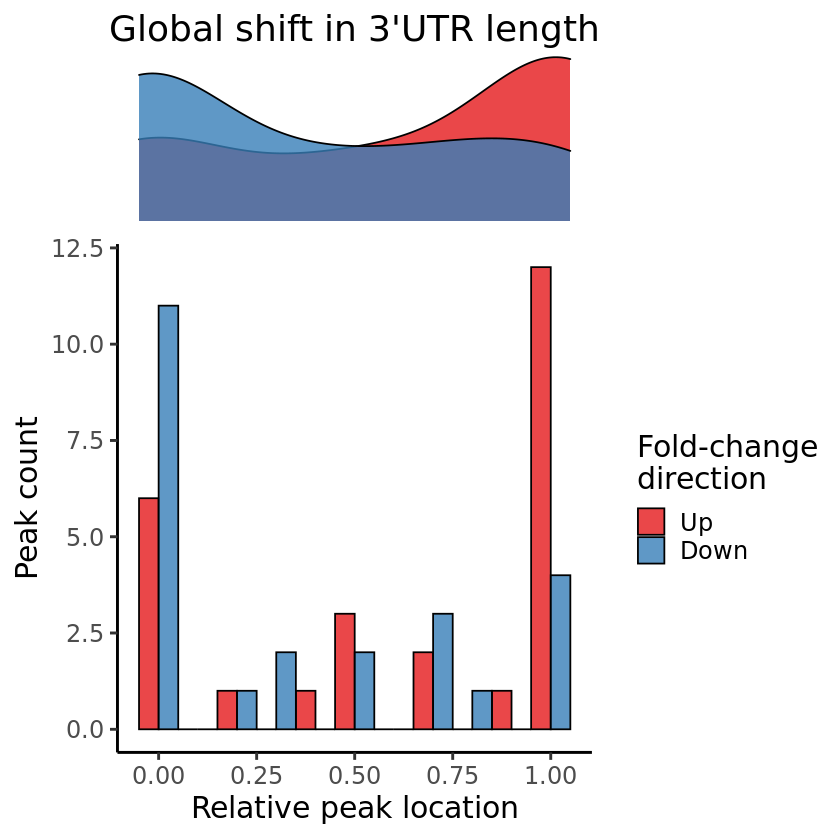

In [109]:
## lets go one celltype at a time
Exc_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so_filtered_renamed, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Excit', 
                                      population.2 = 'NC_Excit')
Exc_utrshift
PlotUTRLengthShift(Exc_utrshift)

genomic_feature(s) population1_pct
SRSF5:chr14:69771448-69772005:1       UTR3               0.26173800     
CCDC144A:chr17:16734833-16735574:1    UTR3               0.16977951     
CNTNAP1:chr17:42699856-42699993:1     UTR3               0.10518807     
VSNL1:chr2:17656028-17656472:1        UTR3               0.13294423     
LUC7L3:chr17:50751561-50752402:1      UTR3               0.19481193     
LUC7L3:chr17:50752203-50752724:1      UTR3               0.23566796     
MPRIP:chr17:17185053-17185706:1       UTR3               0.10259403     
CELF2:chr10:11330239-11331091:1       UTR3               0.15045396     
CELF2:chr10:11329774-11331088:1       UTR3               0.15667964     
SLC6A1:chr3:11037984-11038446:1       UTR3               0.17717250     
SRSF11:chr1:70250468-70251421:1       UTR3               0.12671855     
TSPAN7:chrX:38688131-38688539:1       UTR3               0.08184176     
CALM3:chr19:46608478-46609319:1       UTR3               0.07055772     
SPOCK1:chr5:136978142-136978670:-1    UTR3               0.10505837     
GPM6A:chr4:175633889-175635503:-1     UTR3               0.11297017     
RTN4:chr2:54972772-54973246:-1        UTR3               0.12529183     
HSP90AA1:chr14:102084828-102085242:-1 UTR3               0.10869001     
ELAVL3:chr19:11451326-11451503:-1     UTR3               0.11335927     
PPP2R2B:chr5:147033658-147081692:-1   UTR3               0.07859922     
                                      population2_pct pvalue       padj        
SRSF5:chr14:69771448-69772005:1       0.24585159      2.594317e-08 5.497790e-06
CCDC144A:chr17:16734833-16735574:1    0.16952078      3.832569e-07 6.091389e-05
CNTNAP1:chr17:42699856-42699993:1     0.07672906      1.804496e-06 1.912014e-04
VSNL1:chr2:17656028-17656472:1        0.16235232      2.350342e-05 1.245192e-03
LUC7L3:chr17:50751561-50752402:1      0.22408071      2.202349e-17 5.600574e-14
LUC7L3:chr17:50752203-50752724:1      0.24784282      1.825080e-07 3.262294e-05
MPRIP:chr17:17185053-17185706:1       0.13102350      8.060108e-11 5.716297e-08
CELF2:chr10:11330239-11331091:1       0.19049515      2.529978e-08 5.497790e-06
CELF2:chr10:11329774-11331088:1       0.19421213      1.047401e-06 1.331770e-04
SLC6A1:chr3:11037984-11038446:1       0.21545201      7.979135e-08 1.560842e-05
SRSF11:chr1:70250468-70251421:1       0.12186380      4.447566e-07 6.653035e-05
TSPAN7:chrX:38688131-38688539:1       0.13872295      4.367316e-06 3.422123e-04
CALM3:chr19:46608478-46609319:1       0.10394265      1.008635e-04 3.946091e-03
SPOCK1:chr5:136978142-136978670:-1    0.10380990      3.595981e-06 3.153304e-04
GPM6A:chr4:175633889-175635503:-1     0.13367848      4.178420e-06 3.422123e-04
RTN4:chr2:54972772-54973246:-1        0.11841232      6.015000e-06 4.134094e-04
HSP90AA1:chr14:102084828-102085242:-1 0.10115492      2.566851e-05 1.298112e-03
ELAVL3:chr19:11451326-11451503:-1     0.09252622      4.940681e-05 2.343925e-03
PPP2R2B:chr5:147033658-147081692:-1   0.10752688      8.765776e-10 3.715228e-07
                                      Log2_fold_change SiteLocation NumSites
SRSF5:chr14:69771448-69772005:1        0.2943757       2            2       
CCDC144A:chr17:16734833-16735574:1     0.2591989       3            4       
CNTNAP1:chr17:42699856-42699993:1      0.3318607       3            3       
VSNL1:chr2:17656028-17656472:1         0.2644265       5            5       
LUC7L3:chr17:50751561-50752402:1      -0.3853938       1            3       
LUC7L3:chr17:50752203-50752724:1      -0.2655068       2            3       
MPRIP:chr17:17185053-17185706:1       -0.3613295       1            3       
CELF2:chr10:11330239-11331091:1       -0.3101263       2            8       
CELF2:chr10:11329774-11331088:1       -0.2826746       1            8       
SLC6A1:chr3:11037984-11038446:1       -0.2514358       2            5       
SRSF11:chr1:70250468-70251421:1       -0.3052104       2            4       
TSPAN7:chrX:38688131-38688539:1       -0.2803529      

Warning message in wilcox.test.default(pos.upreg, pos.downreg):
"cannot compute exact p-value with ties"


[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 0.156701377616156"


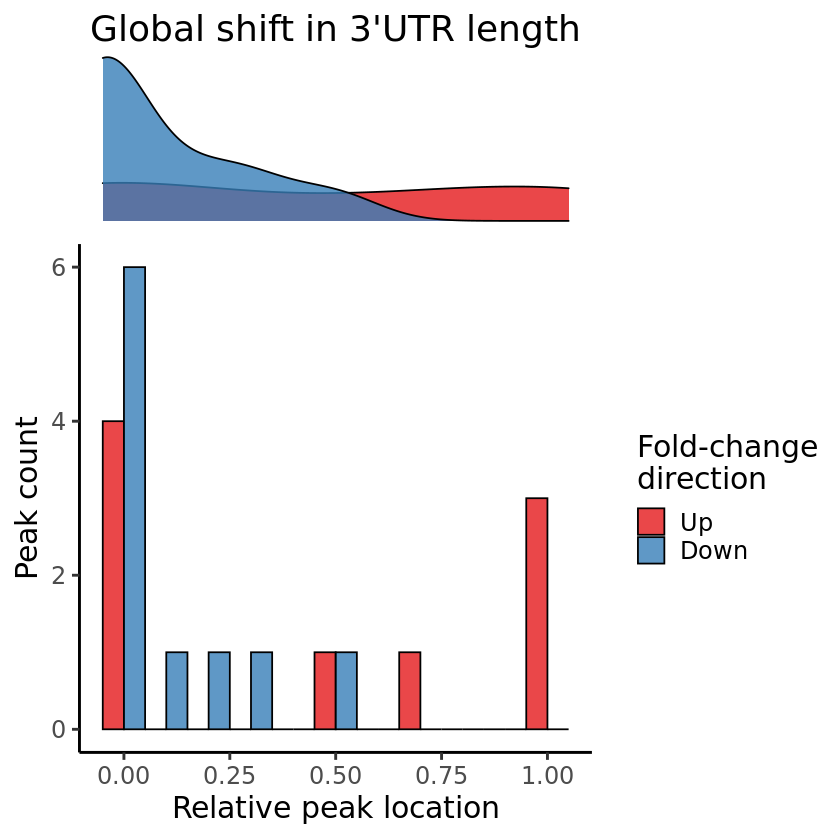

In [112]:
# Inh_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so_filtered_renamed, 
#                                       gtf_gr = gtf_gr,
#                                       gtf_TxDb = gtf_TxDb,
#                                       population.1 = 'AD_Inhit', 
#                                       population.2 = 'NC_Inhit')
Inh_utrshift
PlotUTRLengthShift(Inh_utrshift)

In [113]:
saveRDS(peaks_so_filtered_renamed, file = 'rdata/shun_ad_ct_filtered_authors_md_matched.rds')

In [20]:
nc_samples_peaks_so <- subset(peaks_so_filtered_renamed, subset= condition=='NC')
metadata_df <- nc_samples_peaks_so@meta.data
metadata_df
write.table(metadata_df, file='rdata/control_NC_metadata.tsv')

In [19]:
getwd()

[1] "/data1/APA/Shun_Lau/data"

In [21]:
peaks_so_filtered_renamed

An object of class Seurat 
363250 features across 110019 samples within 1 assay 
Active assay: RNA (363250 features, 0 variable features)

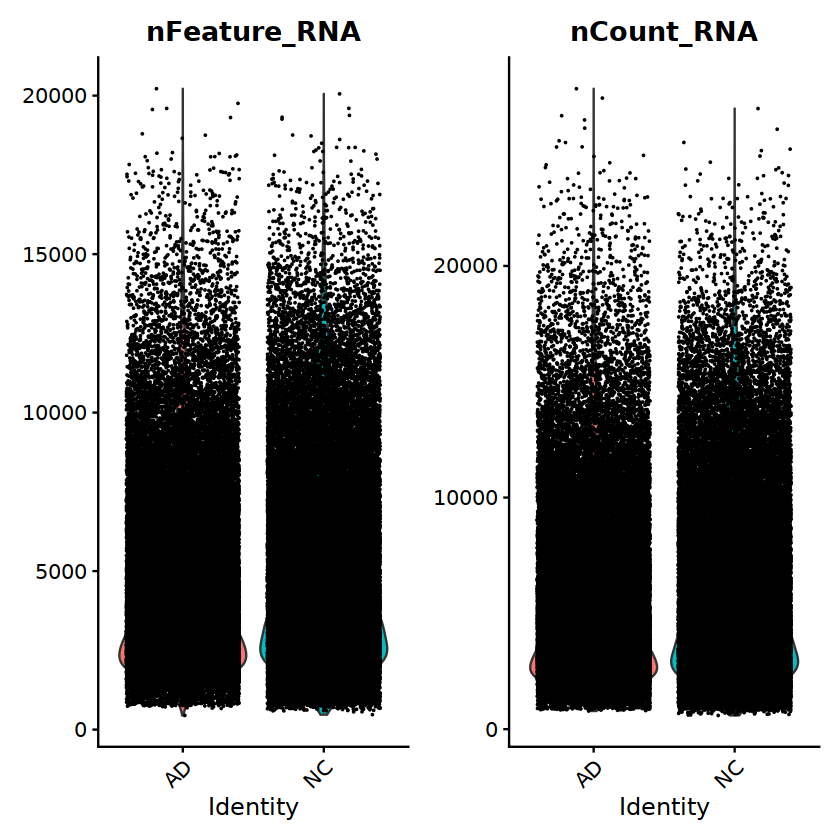

In [23]:
peaks_so_filtered_renamed <- SetIdent(peaks_so_filtered_renamed, value = peaks_so_filtered_renamed$cond)
VlnPlot(peaks_so_filtered_renamed, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

In [25]:
count_per_sample <- data.frame(samples=peaks_so_filtered_renamed$samples, peak_count=peaks_so_filtered_renamed$nCount_RNA,
                               features=peaks_so_filtered_renamed$nFeature_RNA)
count_per_sample <- count_per_sample %>%
  group_by(samples) %>%
  summarise(median_peak_count = median(peak_count), median_feature_count=median(features))
count_per_sample

samples median_peak_count median_feature_count
1  AD1     4993.5            4158.0              
2  AD10    4623.0            3965.0              
3  AD13    5396.5            3946.0              
4  AD19    6652.0            5246.0              
5  AD2     4301.0            3667.0              
6  AD20    4771.0            4016.0              
7  AD21    3944.0            3292.0              
8  AD4     4313.0            3595.0              
9  AD5     3578.0            3076.5              
10 AD8     4591.0            3486.5              
11 AD9     3929.0            3282.0              
12 NC11    3599.0            2712.0              
13 NC12    4578.0            3905.0              
14 NC14    6053.0            5094.0              
15 NC15    5696.0            4868.0              
16 NC16    1781.0            1439.0              
17 NC17    4583.0            3932.5              
18 NC18    5267.0            4424.0              
19 NC3     5008.0            4138.0              
20 NC7     5026.0            4221.0

In [28]:
peaks_so_nc <- subset(peaks_so_filtered_renamed, subset= cond=='NC')
mean(peaks_so_nc$nCount_RNA)

[1] 5982.749

# Chapter two
## lets take a look at ADshun vs CTdim results :/

In [4]:
## lets first get the metadata for the two studies
ad_ct_so <- readRDS('rdata/shun_ad_ct_filtered_authors_md_matched.rds')
ad_ct_so

An object of class Seurat 
363250 features across 110019 samples within 1 assay 
Active assay: RNA (363250 features, 0 variable features)

In [12]:
shun_md <- ad_ct_so@meta.data
shun_md_ad <- shun_md %>% filter(cond=='AD')
rownames(shun_md_ad) <- shun_md_ad$cellnames
remove(ad_ct_so)

In [13]:
## now lets get the CTdim metadata
ct_dim_so <- readRDS('/data/APAproject/post_qual/data/Dimitry_Velmeshev_ASD/rdata/Control_cell_types_GE_PFC.rds')
ct_dim_so

An object of class Seurat 
65217 features across 30147 samples within 1 assay 
Active assay: RNA (65217 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, tsne

In [14]:
table(ct_dim_so$diagnosis)


Control 
  30147 

In [15]:
dim_md <- ct_dim_so@meta.data
dim_md_ct <- dim_md %>% filter(diagnosis=='Control')
remove(ct_dim_so)
dim_md_ct

orig.ident    nCount_RNA nFeature_RNA
AAACCTGAGATGGCGT-1_4341_BA46 SeuratProject  1121       792        
AAACCTGAGCTAACTC-1_4341_BA46 SeuratProject   928       658        
AAACCTGAGTGTTAGA-1_4341_BA46 SeuratProject 13640      4890        
AAACCTGCACCCATTC-1_4341_BA46 SeuratProject  8526      3967        
AAACCTGTCTCATTCA-1_4341_BA46 SeuratProject   846       621        
AAACCTGTCTTAGCCC-1_4341_BA46 SeuratProject 22991      6770        
AAACGGGAGAACAATC-1_4341_BA46 SeuratProject  3082      1949        
AAACGGGAGAGCAATT-1_4341_BA46 SeuratProject  1573      1000        
AAACGGGAGCGGCTTC-1_4341_BA46 SeuratProject  2457      1620        
AAACGGGAGGACGAAA-1_4341_BA46 SeuratProject  1584      1091        
AAACGGGGTCGGCATC-1_4341_BA46 SeuratProject 23815      6891        
AAACGGGGTTCTGGTA-1_4341_BA46 SeuratProject  2962      1865        
AAACGGGTCCACGTTC-1_4341_BA46 SeuratProject  1550      1010        
AAAGATGAGCTACCGC-1_4341_BA46 SeuratProject  2792      1545        
AAAGATGCAGATTGCT-1_4341_BA46 SeuratProject  1343       892        
AAAGATGCAGCGTCCA-1_4341_BA46 SeuratProject 12093      4866        
AAAGATGGTACCGCTG-1_4341_BA46 SeuratProject 16830      5723        
AAAGATGGTCACTGGC-1_4341_BA46 SeuratProject  1615       998        
AAAGATGGTCCGAATT-1_4341_BA46 SeuratProject  7301      3476        
AAAGATGGTGCTCTTC-1_4341_BA46 SeuratProject   717       533        
AAAGATGGTGGTACAG-1_4341_BA46 SeuratProject 10908      4554        
AAAGCAAAGAACAATC-1_4341_BA46 SeuratProject   959       674        
AAAGCAAAGGCGTACA-1_4341_BA46 SeuratProject  2816      1627        
AAAGCAAAGGCTATCT-1_4341_BA46 SeuratProject  1213       783        
AAAGCAACACAACGTT-1_4341_BA46 SeuratProject   687       521        
AAAGCAACAGCTGGCT-1_4341_BA46 SeuratProject  1088       820        
AAAGCAAGTAAGTGGC-1_4341_BA46 SeuratProject  1452       975        
AAAGCAAGTGGTAACG-1_4341_BA46 SeuratProject  4179      2232        
AAAGCAAGTGGTGTAG-1_4341_BA46 SeuratProject  2526      1613        
AAAGCAAGTTAGGGTG-1_4341_BA46 SeuratProject  5775      2749        
⋮                            ⋮             ⋮          ⋮           
TTCTCCTCATACGCCG-1_5976_BA9  SeuratProject  2607      1688        
TTCTTAGTCAGCTGGC-1_5976_BA9  SeuratProject  1382       906        
TTCTTAGTCCGCGTTT-1_5976_BA9  SeuratProject   744       513        
TTGAACGAGTTTCCTT-1_5976_BA9  SeuratProject   961       734        
TTGACTTAGATGTGGC-1_5976_BA9  SeuratProject  2304      1402        
TTGACTTCATGAAGTA-1_5976_BA9  SeuratProject  1485      1008        
TTGCCGTCAGGGCATA-1_5976_BA9  SeuratProject   861       643        
TTGCCGTCAGTAACGG-1_5976_BA9  SeuratProject  7917      3296        
TTGCCGTTCGCACTCT-1_5976_BA9  SeuratProject  4078      2139        
TTGCGTCCACTTCGAA-1_5976_BA9  SeuratProject  1123       793        
TTGCGTCCAGGATCGA-1_5976_BA9  SeuratProject  1657      1147        
TTGCGTCCAGGTGGAT-1_5976_BA9  SeuratProject  4739      2268        
TTGGAACTCATGCAAC-1_5976_BA9  SeuratProject   755       577        
TTGGCAAAGATGTGGC-1_5976_BA9  SeuratProject   902       645        
TTGGCAACAATTCCTT-1_5976_BA9  SeuratProject  7936      3420        
TTGGCAATCAACGGGA-1_5976_BA9  SeuratProject   688       541        
TTGTAGGAGAATGTTG-1_5976_BA9  SeuratProject  2546      1565        
TTGTAGGGTATTAGCC-1_5976_BA9  SeuratProject  3691      1959        
TTGTAGGTCACTTATC-1_5976_BA9  SeuratProject  4853      2305        
TTTACTGCATACGCCG-1_5976_BA9  SeuratProject 19924      6057        
TTTACTGGTCGCCATG-1_5976_BA9  SeuratProject  1217       970        
TTTACTGTCTCTGCTG-1_5976_BA9  SeuratProject  6166      2903        
TTTATGCAGAGACGAA-1_5976_BA9  SeuratProject  1514      1016        
TTTATGCGTCCGTGAC-1_5976_BA9  SeuratProject  3327      1766        
TTTCCTCCAATGGAGC-1_5976_BA9  SeuratProject 10997      4212        
TTTCCTCCACACATGT-1_5976_BA9  SeuratProject 15661      4775        
TTTCCTCGTTCAGTAC-1_5976_BA9  SeuratProject   714       525        
TTTGGTTGTTTACTCT-1_5976_BA9  SeuratProject   787       623        
TTTGTCACA

In [21]:
shun_md_ad

orig.ident    nCount_RNA nFeature_RNA
AAACCCAAGAAACCCG_AD10 SeuratProject  8653       7234       
AAACCCAAGCAATAGT_AD10 SeuratProject 14372      11448       
AAACCCAAGTGAATAC_AD10 SeuratProject  6614       5686       
AAACCCACACAAGGTG_AD10 SeuratProject  1860       1614       
AAACCCACATAGAAAC_AD10 SeuratProject 13146      10260       
AAACCCACATCAGCAT_AD10 SeuratProject  1898       1724       
AAACCCAGTAGATGTA_AD10 SeuratProject  8914       6532       
AAACCCAGTCATCGGC_AD10 SeuratProject  2914       2486       
AAACCCAGTGTACAGG_AD10 SeuratProject  4355       3596       
AAACCCAGTTCTCCCA_AD10 SeuratProject  3282       2881       
AAACCCATCACGTCCT_AD10 SeuratProject  8378       6994       
AAACCCATCACTTCTA_AD10 SeuratProject  5072       4166       
AAACGAAAGACTCAAA_AD10 SeuratProject  8138       6861       
AAACGAAAGATGGCGT_AD10 SeuratProject  8333       6905       
AAACGAAAGCACTCAT_AD10 SeuratProject  4364       3679       
AAACGAAAGTGGAAAG_AD10 SeuratProject  7624       6369       
AAACGAACAAGGCGTA_AD10 SeuratProject  3693       3186       
AAACGAACACGGCCAT_AD10 SeuratProject  3754       3228       
AAACGAACATGACGTT_AD10 SeuratProject  4907       4288       
AAACGAACATGACTCA_AD10 SeuratProject  3457       3020       
AAACGAAGTAAGCGGT_AD10 SeuratProject  4399       3717       
AAACGAAGTATGCGGA_AD10 SeuratProject  1654       1484       
AAACGAAGTGGCCACT_AD10 SeuratProject  3488       3104       
AAACGAAGTTTACTTC_AD10 SeuratProject  7642       6391       
AAACGAATCAACTTTC_AD10 SeuratProject  8617       7160       
AAACGAATCCGTGACG_AD10 SeuratProject  2656       2355       
AAACGCTAGAGCTTTC_AD10 SeuratProject  2029       1804       
AAACGCTAGGGCCAAT_AD10 SeuratProject  2389       2103       
AAACGCTAGTCTTGGT_AD10 SeuratProject  9781       8025       
AAACGCTCAACGATCT_AD10 SeuratProject  6043       5132       
⋮                     ⋮             ⋮          ⋮           
TTTCGATGTACGACTT_AD9  SeuratProject  4991      4250        
TTTGACTGTGAATTAG_AD9  SeuratProject  6990      5557        
TTTGACTGTTACCCTC_AD9  SeuratProject  3587      2988        
TTTGACTTCAACTTTC_AD9  SeuratProject  5403      4166        
TTTGATCAGCTCGAAG_AD9  SeuratProject  2471      2076        
TTTGATCAGGCCGCTT_AD9  SeuratProject  3455      2773        
TTTGATCGTGGGCTCT_AD9  SeuratProject  3717      3058        
TTTGGAGAGAAACTGT_AD9  SeuratProject  1896      1711        
TTTGGAGCAGTCGGTC_AD9  SeuratProject  4417      3820        
TTTGGAGGTGAGTGAC_AD9  SeuratProject  1749      1496        
TTTGGAGGTGTCCCTT_AD9  SeuratProject  1918      1662        
TTTGGAGGTTATCTGG_AD9  SeuratProject  1523      1360        
TTTGGAGTCCACCTCA_AD9  SeuratProject  3424      2862        
TTTGGAGTCCTACAAG_AD9  SeuratProject  6258      5149        
TTTGGAGTCGCTAATG_AD9  SeuratProject  3640      2086        
TTTGGTTAGCCTTTCC_AD9  SeuratProject  4662      3985        
TTTGGTTAGGATACGC_AD9  SeuratProject  3314      2758        
TTTGGTTCAGATCATC_AD9  SeuratProject  4117      3400        
TTTGGTTGTCCAGCAC_AD9  SeuratProject  3745      3093        
TTTGGTTGTGAACGGT_AD9  SeuratProject  1602      1489        
TTTGGTTGTGCCTGCA_AD9  SeuratProject  2757      2370        
TTTGGTTTCAAGGCTT_AD9  SeuratProject  4123      3513        
TTTGGTTTCCCGTGTT_AD9  SeuratProject  2681      2232        
TTTGGTTTCGAAGAAT_AD9  SeuratProject  3122      2636        
TTTGGTTTCTAGGCAT_AD9  SeuratProject  5216      4061        
TTTGTTGAGGACAGTC_AD9  SeuratProject 11393      8871        
TTTGTTGCAAAGGGCT_AD9  SeuratProject  7826      6088        
TTTGTTGGTCCGGACT_AD9  SeuratProject  7255      5771        
TTTGTTGGTTACTCAG_AD9  SeuratProject  3434      2822        
TTTGTTGTCACAAGGG_AD9  SeuratProject  2220      1892        
                      cellnames             percent.mt nCount_SCT nFeature_SCT
AAACCCAAGAAACCCG_AD10 AAACCCAAGAAACCCG_AD10 2.8123559  1831       1572        
AAACCCAAGCAATAGT_AD10 AAACCCAAGCAATAGT_AD10 1.9445330  2037       1753        
AAACCCAAGTGAATAC_AD10 AAACCCAAGTGAATAC_AD10 4.3381535  1696      

In [24]:
# rownames(dim_md_ct) <- gsub("-1", "", rownames(dim_md_ct))
dim_md_ct$ct_cnd <- paste0('CT_',dim_md_ct$main_cellType)
dim_md_ct$cond <- dim_md_ct$diagnosis

In [19]:
allcells <- c(rownames(shun_md_ad), rownames(dim_md_ct))
length(allcells)

[1] 86136

In [17]:
reference.file <- '/home/aiden/data/refgenome/refdata-gex-GRCh38-2020-A/genes//genes.gtf'
gtf_gr <- rtracklayer::import(reference.file)
gtf_TxDb <- GenomicFeatures::makeTxDbFromGFF(reference.file, format="gtf")
peak.annotations <- read.table("/data/APAproject/post_qual/data/control_vs_pathology/sierra_ADshun_CTdim/ADshun_CTdim_peaks_annotated.txt", 
                               header = TRUE,
                               sep = "\t",
                               row.names = 1,
                               stringsAsFactors = FALSE)
peak.counts <- ReadPeakCounts(data.dir = "/data/APAproject/post_qual/data/control_vs_pathology/sierra_ADshun_CTdim/ADshun_CTdim_Sierra_aggregate/")
peaks_so <- NewPeakSeurat(peak.data = peak.counts, 
                              annot.info = peak.annotations, 
                              min.cells = 50, min.peaks = 200)
peaks_so

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK



[1] "Creating Seurat object with 371707 peaks and 109217 cells"


Warning message:
"The following arguments are not used: row.names"


[1] "Preparing feature table for DEXSeq"
[1] "No t-SNE coodinates included"
[1] "No UMAP coordinates included"


An object of class Seurat 
368879 features across 109215 samples within 1 assay 
Active assay: RNA (368879 features, 0 variable features)

In [20]:
peaks_so$cellnames <- Cells(peaks_so)
peaks_so <- subset(peaks_so, subset= cellnames %in% allcells)
peaks_so

An object of class Seurat 
368879 features across 86136 samples within 1 assay 
Active assay: RNA (368879 features, 0 variable features)

In [31]:
metadata <- data.frame(ct_cnd=c(shun_md_ad$ct_cnd, dim_md_ct$ct_cnd),
                       cellnames=c(rownames(shun_md_ad),rownames(dim_md_ct)))
rownames(metadata) <- metadata$cellnames

In [32]:
peaks_so <-  AddMetaData(peaks_so, metadata = metadata)
table(peaks_so$ct_cnd)


        AD_Astrocytes        AD_Endothelial AD_Excitatory_Neurons 
                 6927                   974                 22858 
AD_Inhibitory_Neurons          AD_Microglia   AD_Oligodendrocytes 
                 2446                  2304                 16218 
               AD_OPC         CT_Astrocytes        CT_Endothelial 
                 4262                  2942                   680 
CT_Excitatory_Neurons CT_Inhibitory_Neurons          CT_Microglia 
                12023                  4336                  1320 
  CT_Oligodendrocytes                CT_OPC 
                 5892                  2954 

[1] "11057 expressed peaks in feature types UTR3"
[1] "10331 peaks after filtering out A-rich annotations"
[1] "2322 genes detected with multiple peak sites expressed"
[1] "7603 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."
[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
KIF1B:chr1:10375224-10376888:1      UTR3               0.17035611     
KIF1B:chr1:10376438-10376866:1      UTR3               0.16558754     
CIRBP:chr19:1274151-1274871:1       UTR3               0.33209380     
PABPN1:chr14:23325733-23326185:1    UTR3               0.56973488     
SEPTIN7:chr7:35904886-35905348:1    UTR3               0.28090822     
CACNG8:chr19:53989718-53990215:1    UTR3               0.38765421     
TACC1:chr8:38852569-38853028:1      UTR3               0.14572579     
PDP1:chr8:93923932-93924405:1       UTR3               0.19209905     
PRKCB:chr16:24215209-24215681:1     UTR3               0.36892992     
RYR2:chr1:237832836-237833325:1     UTR3               0.32623152     
RYR2:chr1:237832456-237832898:1     UTR3               0.08981538     
RYR2:chr1:237830534-237832879:1     UTR3               0.09099659     
CCDC144A:chr17:16711711-16731891:1  UTR3               0.41066585     
CCDC144A:chr17:16727650-16734844:1  UTR3               0.22792895     
CCDC144A:chr17:16731770-16734810:1  UTR3               0.18654300     
CALM1:chr14:90404691-90405093:1     UTR3               0.43105259     
CALM1:chr14:90404757-90404997:1     UTR3               0.38555429     
CALM1:chr14:90404791-90405079:1     UTR3               0.35506169     
CALM1:chr14:90404926-90406075:1     UTR3               0.41600315     
CALM1:chr14:90405109-90405679:1     UTR3               0.27767084     
MAP1B:chr5:72195104-72195374:1      UTR3               0.45222679     
PIK3R1:chr5:68298613-68301821:1     UTR3               0.22022924     
PIK3R1:chr5:68298106-68298843:1     UTR3               0.35549917     
PIK3R1:chr5:68298779-68299279:1     UTR3               0.02983638     
DPYSL2:chr8:26657168-26657504:1     UTR3               0.13268877     
DPYSL2:chr8:26656907-26657567:1     UTR3               0.15871905     
LUC7L3:chr17:50755687-50756219:1    UTR3               0.11632689     
LUC7L3:chr17:50750670-50751960:1    UTR3               0.08732173     
LUC7L3:chr17:50752154-50752785:1    UTR3               0.21524193     
LUC7L3:chr17:50751561-50752402:1    UTR3               0.15880654     
⋮                                   ⋮                  ⋮              
FKBP3:chr14:45120894-45134464:-1    UTR3               0.155350424    
SMG1:chr16:18807504-18808758:-1     UTR3               0.034298714    
SNRPA1:chr15:101281510-101281779:-1 UTR3               0.031805057    
GRIN2B:chr12:13540227-13540329:-1   UTR3               0.025024062    
CCDC25:chr8:27748135-27756806:-1    UTR3               0.033030011    
ATP2B1:chr12:89590270-89590366:-1   UTR3               0.044448333    
ATP2B1:chr12:89590238-89590364:-1   UTR3               0.053985476    
RTN1:chr14:59596494-59596644:-1     UTR3               0.030930090    
ISG20L2:chr1:156722477-156723197:-1 UTR3               0.020080497    
CEP85L:chr6:118480422-118492575:-1  UTR3               0.052673025    
NDUFAB1:chr16:23582219-23582429:-1  UTR3               0.017324350    
YME1L1:chr10:27136168-27145713:-1   UTR3               0.058579053    
SCAPER:chr15:76753324-76767514:-1   UTR3               0.079665763    
DNAJC19:chr3:180984489-180984693:-1 UTR3               0.009843381    
FAM3C:chr7:121349704-121351161:-1   UTR3               0.047773209    
USP4:chr3:49278114-49278942:-1      UTR3               0.034429959    
MAP9:chr4:155345434-155345986:-1    UTR3               0.040948464    
TMX3:chr18:68676603-68684750:-1     UTR3               0.035523668    
MED31:chr17:6644379-6644781:-1      UTR3               0.021786683    
MED31:chr17:6644252-6644720:-1      UTR3               0.024061598    
SUCLG1:chr2:84423528-84423760:-1    UTR3               0.035304926    
NDUFS1:chr2:206149033-206153783:-1  UTR3               0.040423484    
ASAP1:chr8:130052672-130053218:-1   UTR3               0.043792108    
PSMA2:chr7:42917460-42917748:-1     UTR3               0.019030536    
PSMA2:chr7:42917360-42917888:-1     UTR3               0.019

[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 5.47487102149691e-15"


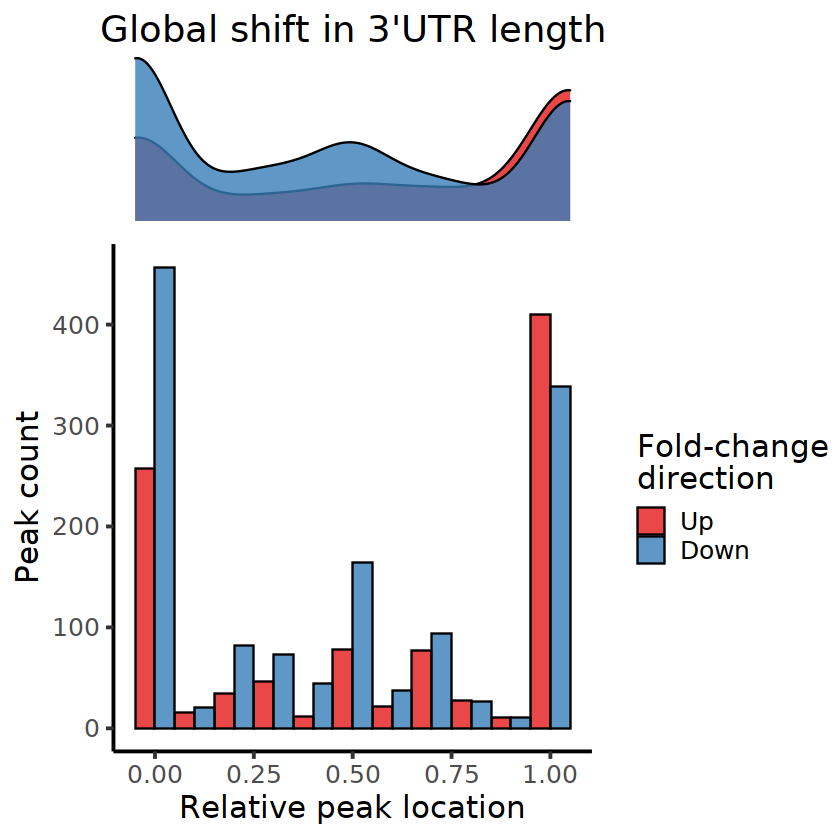

In [34]:
## ok now lets do the utrshift analyis! H0: there shouldn't be many lengthened transcripts
peaks_so <- SetIdent(peaks_so, value = peaks_so$ct_cnd)
Exc_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Excitatory_Neurons', 
                                      population.2 = 'CT_Excitatory_Neurons')
Exc_utrshift
PlotUTRLengthShift(Exc_utrshift)

[1] "8016 expressed peaks in feature types UTR3"
[1] "7520 peaks after filtering out A-rich annotations"
[1] "1685 genes detected with multiple peak sites expressed"
[1] "5128 individual peak sites to test"


converting counts to integer mode

Warning message in DESeqDataSet(rse, design, ignoreRank = TRUE):
"some variables in design formula are characters, converting to factors"


[1] "Running DEXSeq test..."


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

Warning message in vst(exp(alleffects), object):
"Dispersion function not parametric, applying log2(x+ 1) instead of vst...
"


[1] "Detecting shifts in 3'UTR length usage"


genomic_feature(s) population1_pct
SLC6A1:chr3:11038029-11038425:1     UTR3               0.23058054     
SLC6A1:chr3:11037083-11037581:1     UTR3               0.16475879     
SLC6A1:chr3:11038479-11038914:1     UTR3               0.28986100     
SRSF5:chr14:69771597-69772005:1     UTR3               0.26901063     
SRSF5:chr14:69771448-69772005:1     UTR3               0.28699918     
SRSF5:chr14:69771090-69771846:1     UTR3               0.21218316     
MAP1B:chr5:72208246-72208622:1      UTR3               0.12060507     
EIF1:chr17:41691159-41691708:1      UTR3               0.35322976     
CACNG8:chr19:53989718-53990215:1    UTR3               0.34873262     
PABPN1:chr14:23325733-23326185:1    UTR3               0.61529027     
ATP2A2:chr12:110346896-110347352:1  UTR3               0.16639411     
RBM25:chr14:73110585-73114622:1     UTR3               0.12101390     
RBM25:chr14:73110638-73112537:1     UTR3               0.11733442     
RPL5:chr1:92834840-92841924:1       UTR3               0.27596075     
TERF2IP:chr16:75656946-75657498:1   UTR3               0.42395748     
MAPT:chr17:46025548-46026163:1      UTR3               0.17457073     
ADCY1:chr7:45722664-45723116:1      UTR3               0.21300082     
LUC7L3:chr17:50751561-50752402:1    UTR3               0.26533115     
LUC7L3:chr17:50752154-50752785:1    UTR3               0.29926410     
LUC7L3:chr17:50755687-50756219:1    UTR3               0.13164350     
LUC7L3:chr17:50750670-50751960:1    UTR3               0.13327882     
LUC7L3:chr17:50751910-50752228:1    UTR3               0.10834015     
DPYSL2:chr8:26656907-26657567:1     UTR3               0.14063778     
DPYSL2:chr8:26657168-26657504:1     UTR3               0.11283729     
UBA52:chr19:18576984-18577550:1     UTR3               0.11651676     
SEC62:chr3:169995997-169996507:1    UTR3               0.08176615     
SEC62:chr3:169993723-169994196:1    UTR3               0.06541292     
CIRBP:chr19:1274151-1274871:1       UTR3               0.33319706     
GAD2:chr10:26300757-26301621:1      UTR3               0.18438267     
KIF1B:chr1:10376438-10376866:1      UTR3               0.14022895     
⋮                                   ⋮                  ⋮              
ATOX1:chr5:151746191-151746518:-1   UTR3               0.03311529     
SNX14:chr6:85505724-85508296:-1     UTR3               0.08340147     
DLG2:chr11:84058984-84099197:-1     UTR3               0.14595258     
UBE2O:chr17:76389647-76390421:-1    UTR3               0.09689289     
RSRC2:chr12:122508228-122515332:-1  UTR3               0.03229763     
RSRC2:chr12:122514978-122519125:-1  UTR3               0.03515944     
SCAPER:chr15:76753324-76767514:-1   UTR3               0.10302535     
CUL3:chr2:224505493-224514962:-1    UTR3               0.09525756     
SRGAP2B:chr1:144888769-144889549:-1 UTR3               0.03066231     
NRCAM:chr7:108147864-108148902:-1   UTR3               0.12428455     
USP33:chr1:77697285-77701640:-1     UTR3               0.09689289     
SCAI:chr9:124942608-124943004:-1    UTR3               0.04619787     
ETFA:chr15:76216243-76231387:-1     UTR3               0.05846280     
KIAA0930:chr22:45195816-45195906:-1 UTR3               0.10793132     
KDM5B:chr1:202766864-202773342:-1   UTR3               0.04538021     
TMEM246:chr9:101473170-101473677:-1 UTR3               0.07031889     
TMEM246:chr9:101473170-101473507:-1 UTR3               0.06991006     
PSMB1:chr6:170535120-170535395:-1   UTR3               0.07808667     
GRIN2B:chr12:13540227-13540329:-1   UTR3               0.04210957     
SCARB2:chr4:76158737-76159177:-1    UTR3               0.14227310     
TMEM59:chr1:54032079-54032367:-1    UTR3               0.02330335     
SNX3:chr6:108211584-108212094:-1    UTR3               0.08176615     
CEP85L:chr6:118480422-118492575:-1  UTR3               0.07154538     
TPT1:chr13:45336860-45337208:-1     UTR3               0.06623058     
REV3L:chr6:111374669-111375225:-1   UTR3               0.089

[1] "Wilcoxon Rank-sum test comparing relative peak locations for up- vs down-regulated peaks:"
[1] "P-value = 1.92876053421398e-06"


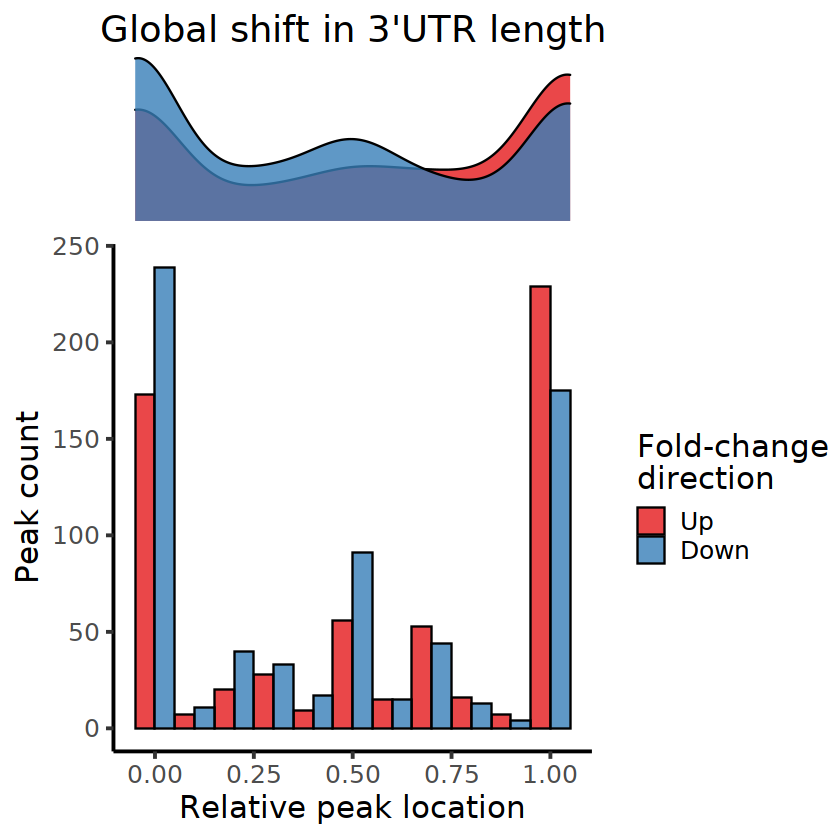

In [35]:
Inh_utrshift <- DetectUTRLengthShift(peaks.object = peaks_so, 
                                      gtf_gr = gtf_gr,
                                      gtf_TxDb = gtf_TxDb,
                                      population.1 = 'AD_Inhibitory_Neurons', 
                                      population.2 = 'CT_Inhibitory_Neurons')
Inh_utrshift
PlotUTRLengthShift(Inh_utrshift)

In [36]:
saveRDS(peaks_so, 'rdata/ADshun_CTdim_peaks_so_md.rds')